# Intro to Fraud Detection

<span>This notebook is an extensive look into different Fraud Detection Models. I started this project without any knowledge of Fraud Detection and slowly worked my up during my education at BrainStation. I initially modeled many more models than presented here, but I decided to cut the majority of them to communicate the best models and reduce the size of this notebook.</span>
    
**Dataset:** [Paysim Transactions Logs](https://www.kaggle.com/ntnu-testimon/paysim1)
    
##### Scientific Notes 

- Most of the heavy lifting is in the function. Please review the function documentation

### Import Preliminaries

In [262]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Import Modules
import datetime
import itertools
import graphviz 
import keras.backend as K
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import scipy
import sklearn
import tensorflow as tf
import warnings
import xgboost

# Other Imports
from matplotlib import rcParams, gridspec
from scipy import io
from xgboost import XGBClassifier

# Keras Imports
from keras import models, layers
from keras import regularizers

from keras.models import Model, load_model, Sequential
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.wrappers.scikit_learn import KerasClassifier

# Scipy Imports
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram, linkage

# Preprocesing
from sklearn.decomposition import PCA
from sklearn.externals import joblib
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.preprocessing import StandardScaler

# Sklearn Models
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.cluster import DBSCAN
from sklearn.cluster import MeanShift
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, LocalOutlierFactor
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC, SVC, OneClassSVM
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.class_weight import compute_sample_weight

# Metrics
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report,
                             f1_score, precision_score, recall_score,
                             precision_recall_fscore_support, roc_auc_score)

# Model Selection
from sklearn.model_selection import (cross_val_score, KFold, train_test_split,
                                     GridSearchCV, cross_validate,
                                     StratifiedKFold)


# Set Numpy and Python Random Seed
seed = 7
np.random.seed(seed)

# Pandas Configuration
pd.set_option('max_columns', 1000)
pd.set_option('max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)


# Warning Configuration
warnings.filterwarnings('ignore')

# Plotting Configuration
rcParams['figure.figsize'] = (12.0, 4.0)
rcParams.update({'font.size': 10})
colors = ['#74a9cf', '#6a51a3']

# Print versions of each package above 
print("Numpy version: {}".format(np.__version__))
print("Pandas version: {}".format(pd.__version__))
print("Sklearn version: {}".format(sklearn.__version__))
print("Keras version: {}".format(keras.__version__))
print("Scipy version: {}".format(scipy.__version__))
print("XBG Boost version: {}".format(xgboost.__version__))

Numpy version: 1.14.5
Pandas version: 0.23.4
Sklearn version: 0.19.0
Keras version: 2.2.2
Scipy version: 0.19.1
XBG Boost version: 0.72


<br><br>
<a id='function'></a>
### Functions

I have created many functions to the make later part of our code more simplistic. You will see some measurement functions which we will use in Keras. a few functions used to plot our confusion matrices. Finally a few transformation functions that transform depentand values from +1/1 to 0/1.

In [176]:
def anon_to_target(array):
    '''
    Converts Prediction in the +1/-1 format to 0/1 format for every value in the array

    Parameter
    ---------
    array: numpy array containing only +1/1

    Exmaples
    ---------
    >>>> anon_to_targets([1,1,,1,1,-1,1,-1,1])
    '''

    array = [0 if i == 1 else 1 for i in array]
    array = np.array(array).reshape(1, -1)[0]

    return array

def plot_confusion_anomoly(model, classes, name,
                           train_y, test_y, train_x,test_x,
                           cmap=plt.cm.Purples):
    '''
    Function plots a confusion matrix given train and test 
    unsuperived models

    Parameters
    ----------
    train_model: sklearn/keras model object to be trained on training data
    test_moedl: sklearn/keras model object to be trained on test data

    Examples
    ----------
    >>>> plot_confusion_anomoly(xg_model, train_x, train_y)
    >>>> plot_confusion_anomoly(rf_model, train_x, train_y)
    '''
    rcParams['figure.figsize'] = (30.0, 22.5)

    # Plot Train Confusion Matrix
    fig = gridspec.GridSpec(3,3)
    grid_length = list(range(1,3))
    tuple_grid = [(i,j) for i in grid_length for j in grid_length]

    plt.subplot2grid((3,3), (0,0))
    cm = confusion_matrix(train_y, anon_to_target(model.predict(train_x)))
    plot_confusion_matrix(cm, classes, fontsize=20, 
                          title=name,
                         normalize=True, cmap=cmap)
    
    plt.subplot2grid((3,3), (0,1))
    cm = confusion_matrix(test_y, anon_to_target(model.predict(test_x)))
    plot_confusion_matrix(cm, classes, fontsize=20,
                          title=name,
                         normalize=True, cmap=cmap);

    return None


def plot_confusion_matrix(cm, classes, fontsize=20,
                          normalize=False, title='Confusion matrix',
                          cmap=plt.cm.Blues):
    '''
    THE MAIN CONFUSION MATRIX, KAVI DON'T DELTETE BY ACCIDENT AGAIN. Function plots a 
    confusion matrix given a cm matrix and class names

    Parameters
    ----------
    cm: sklearn confusion matrix
    classes: numpy 1D array containing all unique class names

    Examples
    ---------
    >>>>

    plot_confusion_matrix(
    cm,
    classes,
    fontsize=25,
    normalize=True,
    title=model.name.capitalize() + ': Test Set',
    cmap=plt.cm.Greens)

    '''
    cm_num = cm
    cm_per = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        # print("Normalized confusion matrix")
    else:
        None
        # print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title.replace('_',' ').title()+'\n', size=fontsize)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size=fontsize)
    plt.yticks(tick_marks, classes, size=fontsize)

    fmt = '.5f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        # Set color parameters
        color = "white" if cm[i, j] > thresh else "black"
        alignment = "center"

        # Plot perentage
        text = format(cm_per[i, j], '.5f')
        text = text + '%'
        plt.text(j, i,
            text,
            fontsize=fontsize,
            verticalalignment='baseline',
            horizontalalignment='center',
            color=color)
        # Plot numeric
        text = format(cm_num[i, j], 'd')
        text = '\n \n' + text
        plt.text(j, i,
            text,
            fontsize=fontsize,
            verticalalignment='center',
            horizontalalignment='center',
            color=color)

    plt.tight_layout()
    plt.ylabel('True label'.title(), size=fontsize)
    plt.xlabel('Predicted label'.title(), size=fontsize)

    return None

def plot_confusion_normal(model, classes, name, train_x, train_y,
                          test_x, test_y, cmap=plt.cm.Greens):
    '''
    Fuction plota grid and calls the plot_confusion_matrix function
    to plot two confusion matrices. One for the tarin set and another
    for the test set

    Parameters
    ----------
    cm: sklearn confusion matrix
    classes: numpy 1D array containing all unique class names

    Examples
    ----------
    >>>> plot_confusion_normal(xg_model, train_x, train_y)
    >>>> plot_confusion_normal(rf_model, train_x, train_y)
    '''

    # Set the plot size
    rcParams['figure.figsize'] = (30.0, 22.5)

    # Set up grid
    plt.figure()
    fig = gridspec.GridSpec(3, 3)
    grid_length = list(range(1, 3))
    tuple_grid = [(i, j) for i in grid_length for j in grid_length]

    # Plot Training Confusion Matrix
    plt.subplot2grid((3, 3), (0, 0))
    cm = confusion_matrix(train_y, model.predict(train_x))
    plot_confusion_matrix(
        cm,
        classes=classes,
        normalize=True,
        title=name.capitalize() + ': Train Set',
        cmap=cmap)

    # Plot Testing Confusion Matrix
    plt.subplot2grid((3, 3), (0, 1))
    cm = confusion_matrix(test_y, model.predict(test_x))
    plot_confusion_matrix(
        cm,
        classes=classes,
        normalize=True,
        title=name.capitalize() + ': Test Set',
        cmap=cmap)

    return None        


def plot_confusion_neural(model, classes, train_x, train_y, 
                          test_x, test_y, cmap=plt.cm.Oranges):
    '''
    Funtion to plot a grid and calls the plot_confusion_matrix function
    to plot two confusion matrices. One for the tarin set and another
    for the test set. This function includes a sigmoid function that rounds
    networks prediction before plotting.

    Parameters
    ----------
    cm: sklearn confusion matrix
    classes: numpy 1D array containing all unique class names

    Examples
    ----------
    >>>> plot_confusion_neural(nn_model, train_x, train_y)
    >>>> plot_confusion_neural(autoencoder, train_x, train_y)
    '''

    # Set the plot size
    rcParams['figure.figsize'] = (30.0, 22.5)

    # Set up grid
    plt.figure()
    fig = gridspec.GridSpec(3, 3)
    grid_length = list(range(1, 3))
    tuple_grid = [(i, j) for i in grid_length for j in grid_length]

    # Plot Training Confusion Matrix
    plt.subplot2grid((3, 3), (0, 0))
    cm = confusion_matrix(train_y, model.predict(train_x))
    plot_confusion_matrix(
        cm,
        classes,
        fontsize=25,
        normalize=True,
        title=model.name.capitalize() + ': Train Set',
        cmap=cmap)

    # Plot Testing Confusion Matrix
    plt.subplot2grid((3, 3), (0, 1))
    cm = confusion_matrix(test_y, (model.predict(test_x)))
    plot_confusion_matrix(
        cm,
        classes,
        fontsize=25,
        normalize=True,
        title=model.name.capitalize() + ': Test Set',
        cmap=cmap)

    return None


def target_to_anon(array):
    '''
    Converts prediction in the 
    0/1 standard format to 1/-1 anomoly format for every
    value in the array

    Parameter
    ---------
    array: numpy array containing only +1/1

    Exmaples
    ---------
    >>>> anon_to_targets([1,1,,1,1,-1,1,-1,1])
    '''
    array = [1 if i == 0 else -1 for i in array]
    array = np.array(array).reshape(1,-1)[0]
    return array

### Import Data

In [268]:
# Import paysim data
sdf = read_csv('Data/Synthetic/synthetic.csv')
sdf = sdf.rename(columns={'isfraud':'target', 'oldbalanceorg':'oldbalanceorig'})

### Pay Sim Finanicial Logs

This notebook will tackle a problem that comes from a [PaySim](http://www.diva-portal.org/smash/record.jsf?pid=diva2%3A1058442&dswid=7771) Simulator which has provided a dataset of simulated transactions from one month of financial logs. The logs came from a mobile money service within an unknown African nation. In, this next cells I will use this dataset to review some supervised learning approaches to detection. Agents in this dataset are attempting to control customers accounts and empty the funds by transferring to another account and then cashing out of the system. The "isflaggedfraud" feature in the dataset is flag this active when someone attempts to transact more than 200,000. We will drop this feature from our supervised model as it is a form of data leakage as all 'isflaggedfraud" transactions are fraudulent transactions.

In [94]:
# View head of the dataframe
sdf.head(3)

,step,type,amount,nameorig,oldbalanceorig,newbalanceorig,namedest,oldbalancedest,newbalancedest,target,isflaggedfraud
0,1,PAYMENT,9839.640,C1231006815,170136.000,160296.360,M1979787155,0.000,0.000,0,0
1,1,PAYMENT,1864.280,C1666544295,21249.000,19384.720,M2044282225,0.000,0.000,0,0
2,1,TRANSFER,181.000,C1305486145,181.000,0.000,C553264065,0.000,0.000,1,0


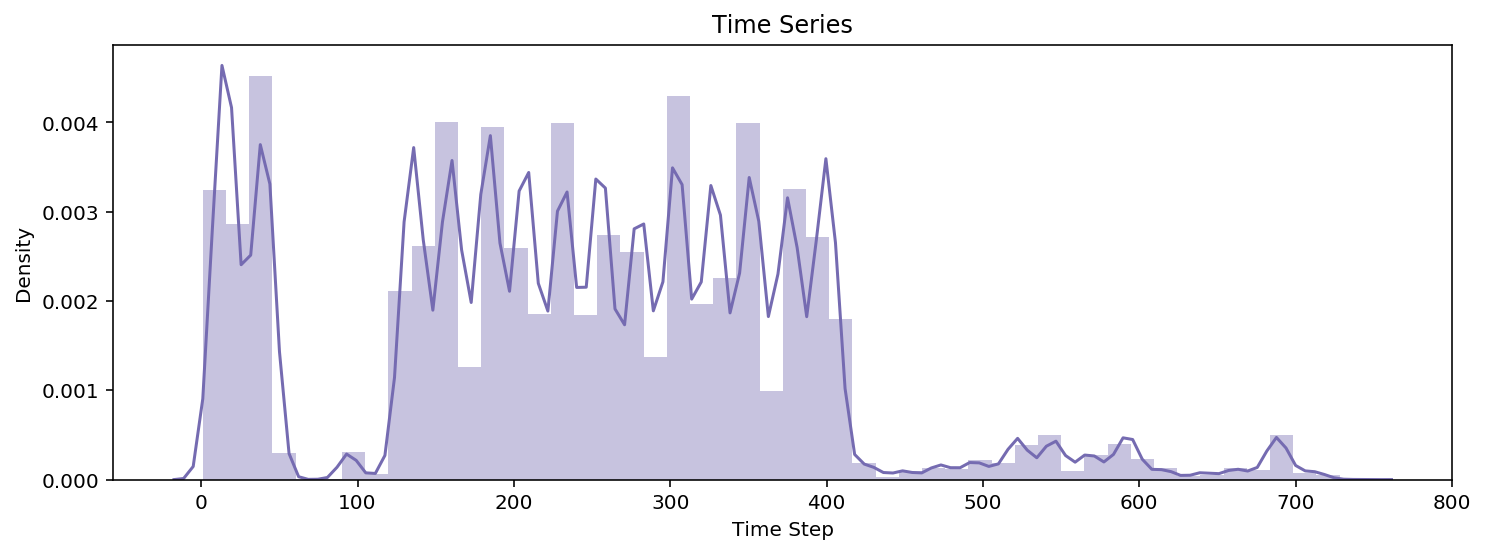

In [95]:
# Plot number of datapoints of each time interval
plt.figure(figsize=(12,4))
sns.distplot(sdf.step, color='#756bb1');
plt.title('Time Series')
plt.xlabel('Time Step'); plt.ylabel('Density');

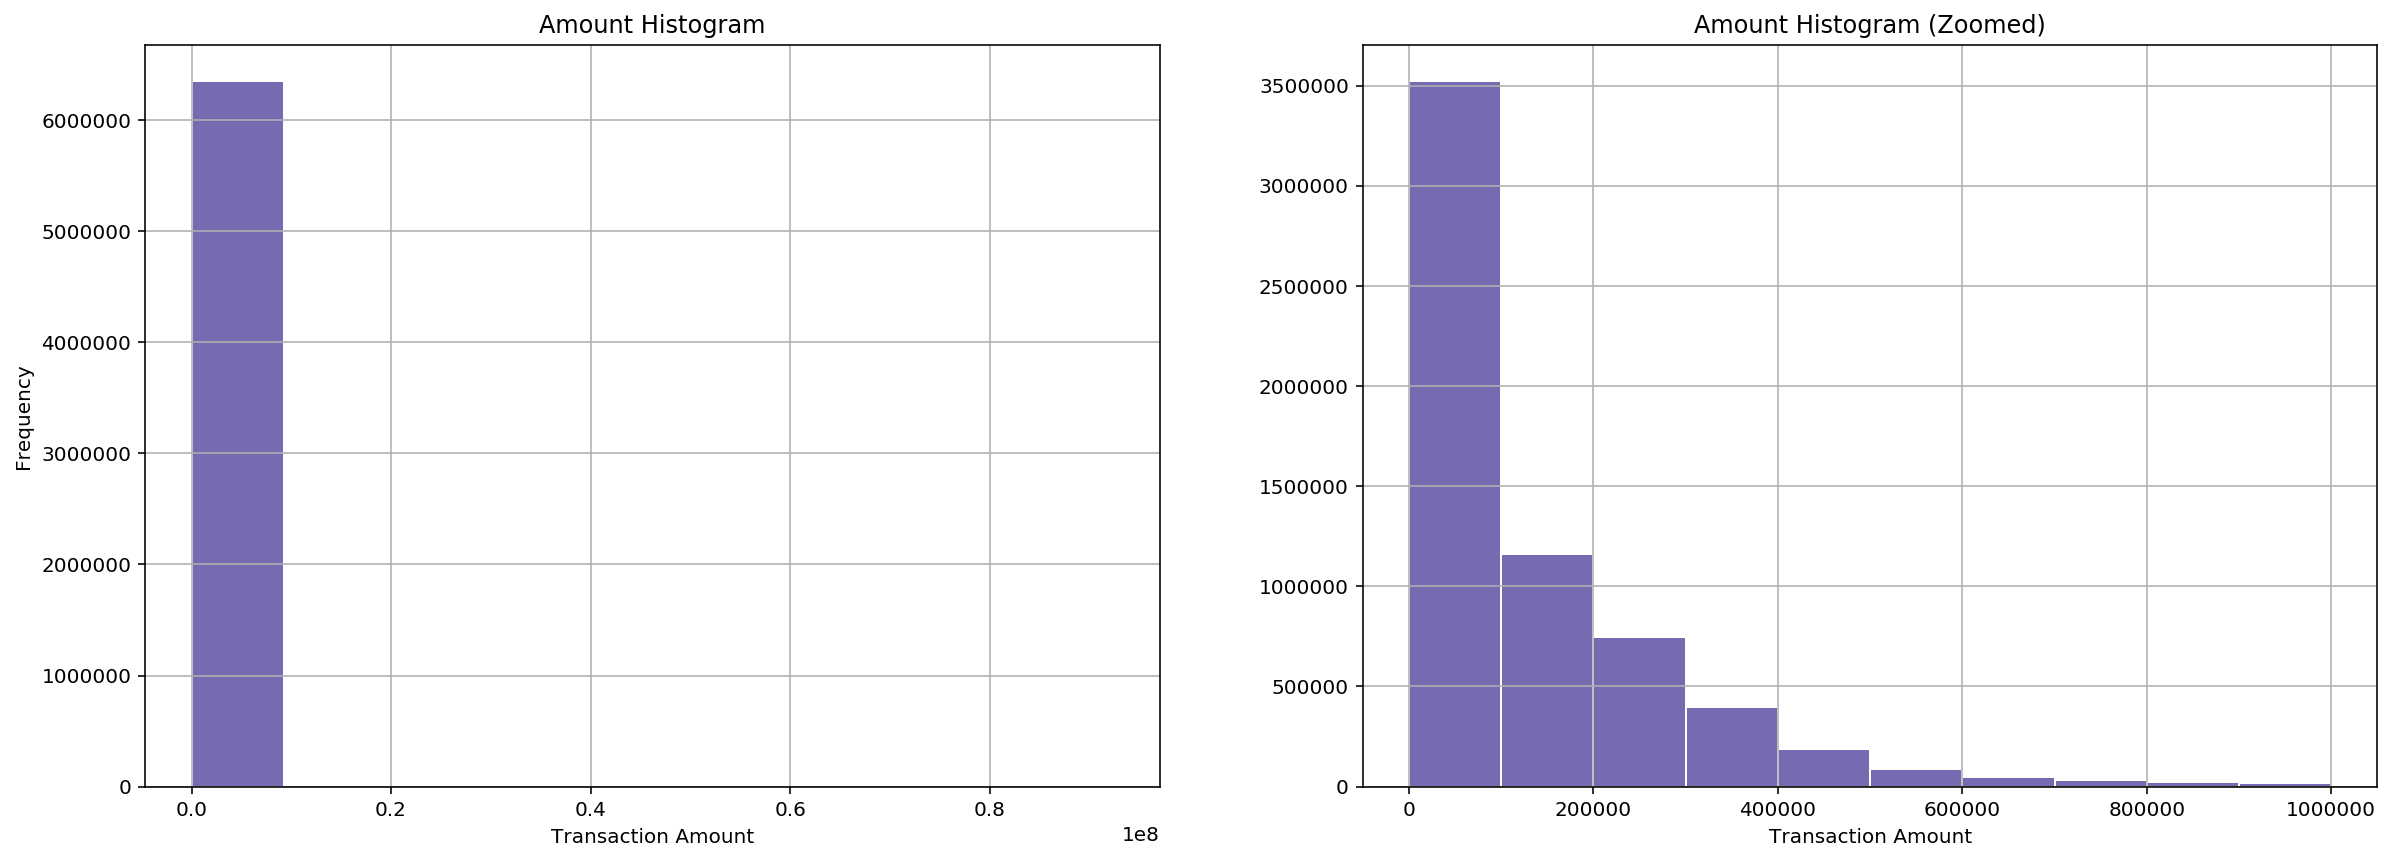

In [96]:
# Plot histograms of amounts
plt.figure(figsize=(20,15))
plt.subplot2grid((2, 2), (0, 0))
sdf.amount.hist(color='#756bb1',  edgecolor='white')
plt.title('Amount Histogram')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency');

# Plot zoomed histograms of amounts
plt.subplot2grid((2, 2), (0, 1))
sdf[sdf.amount < 10_000_00].amount.hist( color='#756bb1',  
                                        edgecolor='white')
plt.title('Amount Histogram (Zoomed)')
plt.xlabel('Transaction Amount');

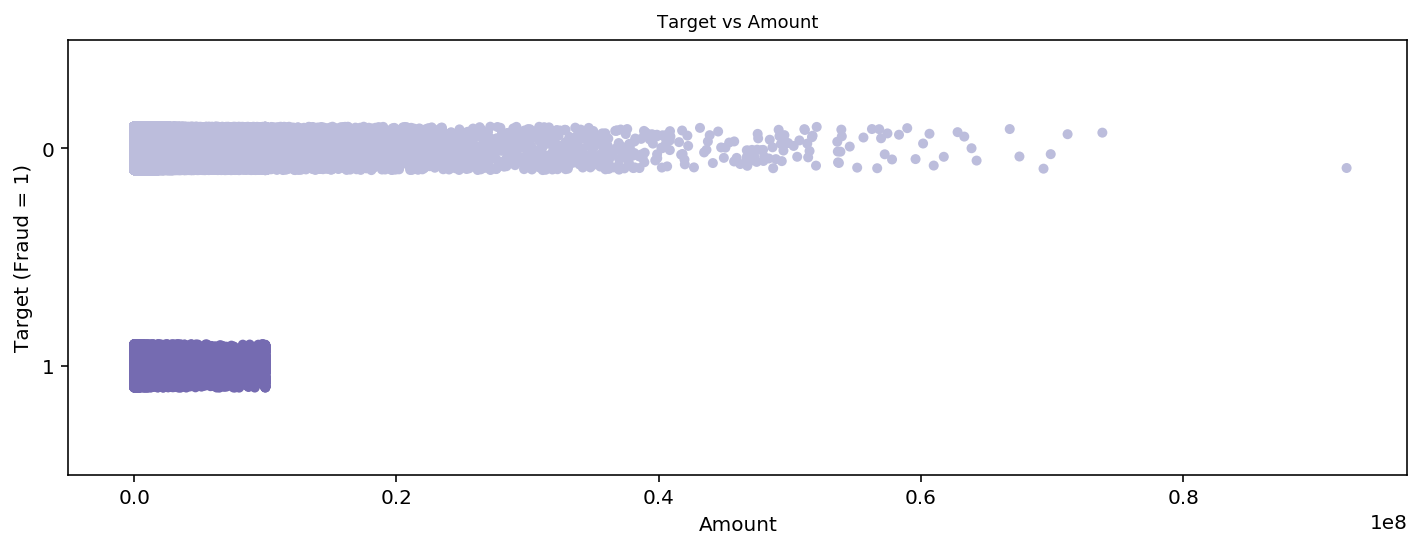

In [263]:
# Plotting frequency of fraud amounts by fraud classification
sns.stripplot(x=sdf["amount"], y=sdf['target'].astype('category'),
             palette=['#bcbddc','#756bb1']);
plt.title('Target vs Amount', fontsize=9)
plt.xlabel('Amount',)
plt.ylabel('Target (Fraud = 1, Not Fraud=0)',);

##### Aggregation Statistics

In [98]:
# View a cross tab for the number of transactions in the dataset
pd.crosstab(sdf.type, sdf.target)

target,0,1
type,,
CASH_IN,1399284,0
CASH_OUT,2233384,4116
DEBIT,41432,0
PAYMENT,2151495,0
TRANSFER,528812,4097


In the description of the data source, the author notes that the cases of fraud within this dataset are acts committed by individuals attempting to empty out a bank account at once. The crosstab shows us that our fraudsters are going about this by transfer the cashout or transferring it to another account.

In [99]:
# Data Leak: All the cases where "isflaggedfraud" = 1, are already
# fraudualent transractions. I will be removing this feature during
# the feature engineering of this dataset.
sdf[['target','isflaggedfraud']].groupby('target').sum()

,isflaggedfraud
target,
0,0
1,16


Know we are going to create some feature that can tell us a bit more about the victim from these fraudulent transactions. I will aggregate our transaction data frame into dataset based on users. The purpose here is to see whether the same users are involved in multiple transactions. Note that this dataset does.

In [100]:
# View accounts that tranfer the amount to their own acccount (None)
sdf[sdf['nameorig'] == sdf['namedest']]

,step,type,amount,nameorig,oldbalanceorig,newbalanceorig,namedest,oldbalancedest,newbalancedest,target,isflaggedfraud


Looks like dataset only containes information on transfer to external accounts, and not transfer to ones own account (chequeing to savings). This is good to know.

In [264]:
# Count how many clients were affected at lease twice
affeceted_clients = sdf[sdf.target == 1]
affeceted_clients[['nameorig','namedest']]
affeceted_clients_list = pd.Series(affeceted_clients['nameorig'], name='clients')
affeceted_clients_list.append(pd.Series(affeceted_clients['namedest']))
affeceted_clients_list = affeceted_clients_list.value_counts()

# Prin counts
print(f'Number of Clients Affected Once: \
{affeceted_clients_list[affeceted_clients_list <= 1].count()}')
print(f'Number of Clients Affected More than once: \
{affeceted_clients_list[affeceted_clients_list > 1].count()}')

Number of Clients Affected Once: 8213
Number of Clients Affected More than once: 0


No one in our fraud dataset has been involved in a case of fraud more than once. Good news seems like there are not repeat bat actors.

##### Assessing Fraudelent Transactions

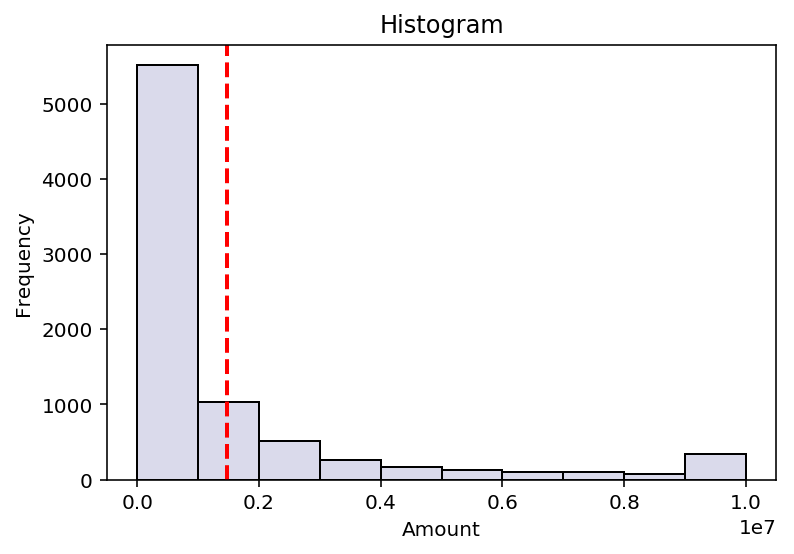

In [265]:
# Histogram of only fraudulent amounts
rcParams['figure.figsize'] = (6.0, 4.0)
fraud_transactions = sdf[sdf.target == 1]
fraud_transactions.amount.plot.hist(color='#dadaeb', 
                                    edgecolor='black', )
plt.title('Histogram')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.axvline(sdf[sdf.target == 1].amount.mean(),  color='r', linestyle='dashed', linewidth=2);

##### Creating a Network Graph

The data is a transaction database retrieved from a relational database. We can you the NetworkX Python package to create a temporary graph database/network. We can then create a network plot to view if there are any patterns within the network.

In [106]:
# Create a list of all the accounts involved in fraud
fraud_case_accounts = sdf[sdf.target == 1][['nameorig','namedest']].values
fraud_case_accounts = fraud_case_accounts.reshape(-1,1)
fraud_case_account_list = np.unique(fraud_case_accounts)

# Generate a dataframe of all the transactions carried out by these
# individuals
sdf_fraud_scope = sdf[(sdf.nameorig.isin(fraud_case_accounts_list)) | (
    sdf.namedest.isin(fraud_case_accounts_list))]

# Print metric counts
print('Number of Cases of Fraud:',sdf[sdf.target == 1].shape[0])
print('Number of Accounts involved in Fraud (2 per transaction):',
      len(fraud_case_account_list))
print('Number of Total Transactions involed with these Accounts:',
     len(sdf_fraud_scope))

Number of Cases of Fraud: 8213
Number of Accounts involved in Fraud (2 per transaction): 16382
Nubmer of Total Transactions involed with these accounts: 65694


First I have graphed the fraudulent transactions in the dataset. Note the arrow within this Bidirectional graph show us the direction in which money is flowing.

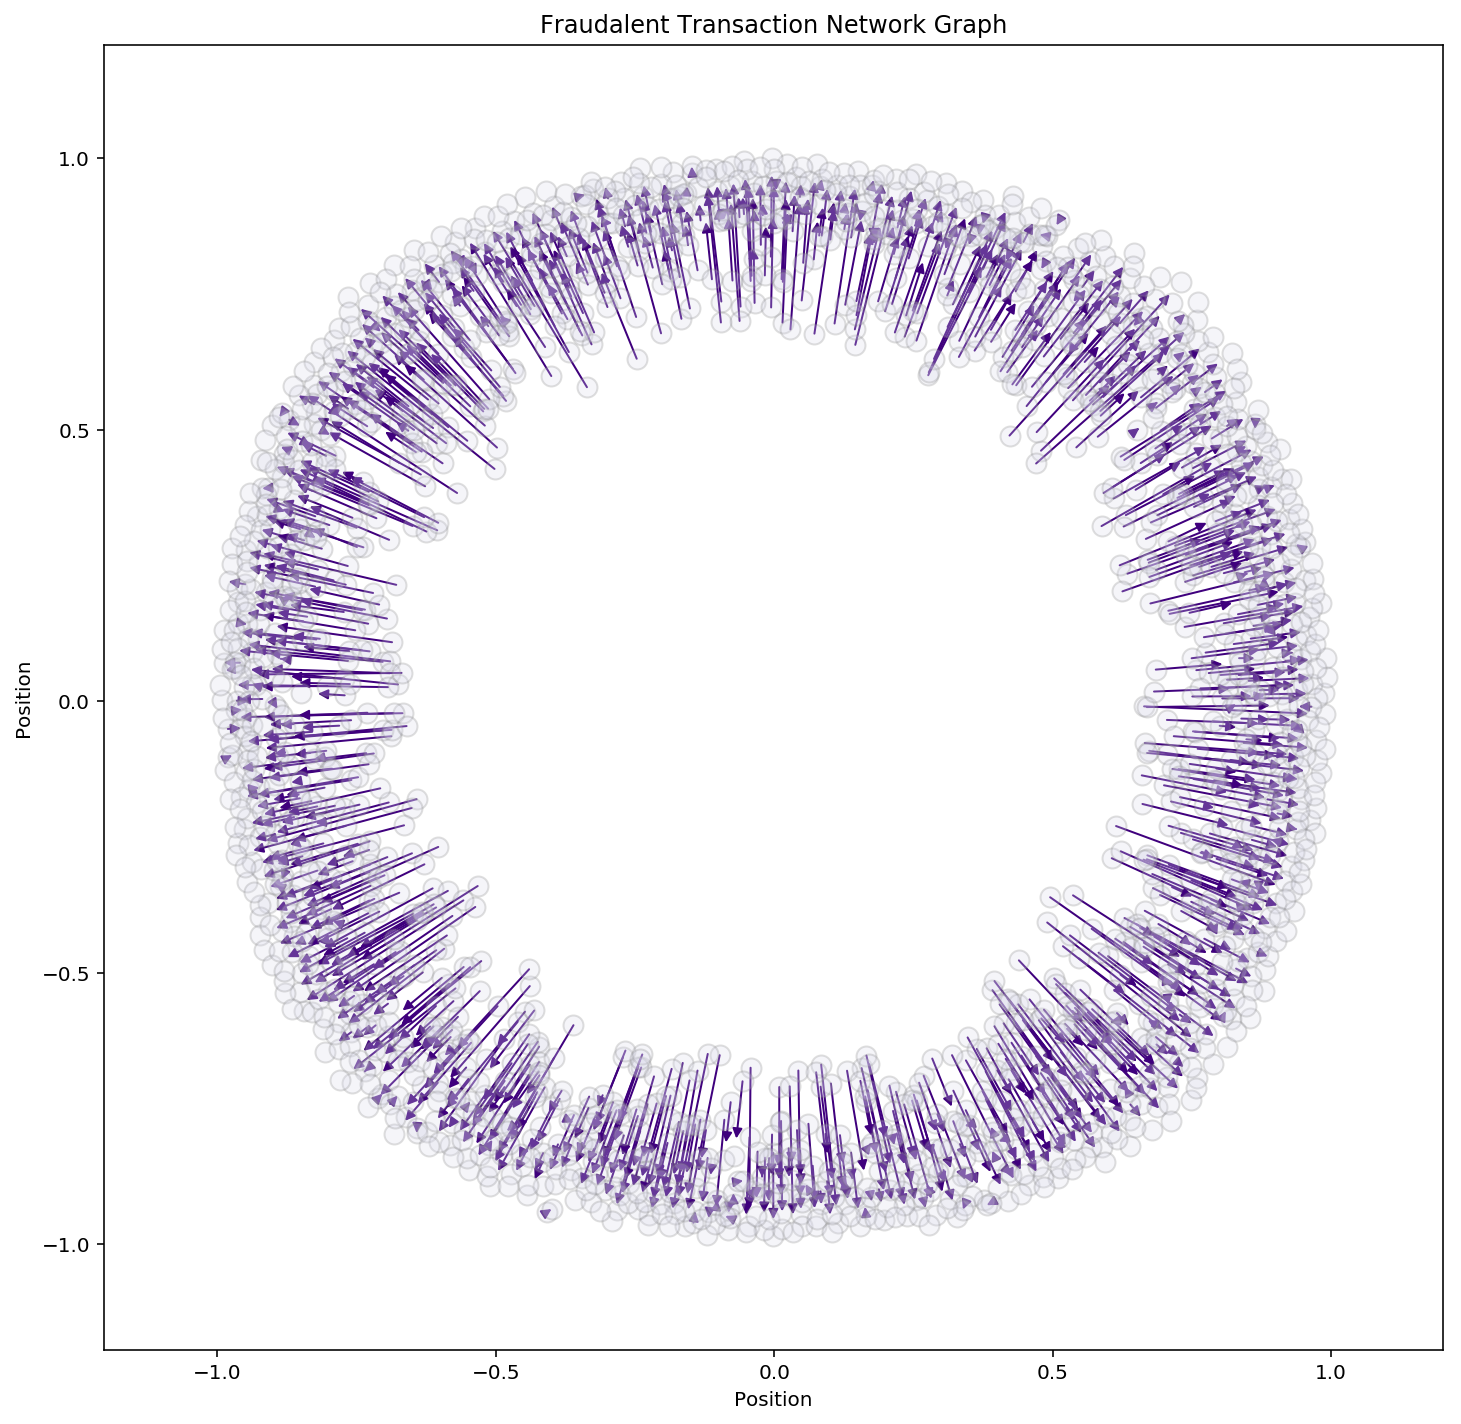

In [107]:
# Segment out graph data
data = sdf[sdf.target == 1].sample(1000)
data = data[['nameorig','namedest','target','amount']]
G = nx.DiGraph()

# Create temporary graph database/network
for i,j,k,l in list(data.itertuples(index=False, name=None)):
    G.add_edge(i,j, target=k, amount=l )

# Plot the graph network
pos=nx.spring_layout(G)
nx.draw_networkx_nodes(G,pos, alpha=0.25,
                       node_size=100,
                       node_color='#dadaeb',
                       edgecolors='grey');
nx.draw_networkx_edges(G,pos,edge_color='#3f007d',
                       width=1,
                       arrowsize=10,
                      arrowstyle='-|>',
                      )
plt.title('Fraudalent Transaction Network Graph')
plt.xlabel('Position')
plt.ylabel('Position');

The plot above is plotting out every fraudulent transaction. The arrow shows us which the money was following. Each not represents a bank account. We can see that many of the bank accounts had been involved in case of fraud once as either the sender and receiver. Next, We will look at all the historical transaction from all these accounts before after the instances of fraud. I want to see if the total amount of transactions show any pattern. If one exists, we could use that information as an explicit feature in our feature engineering.

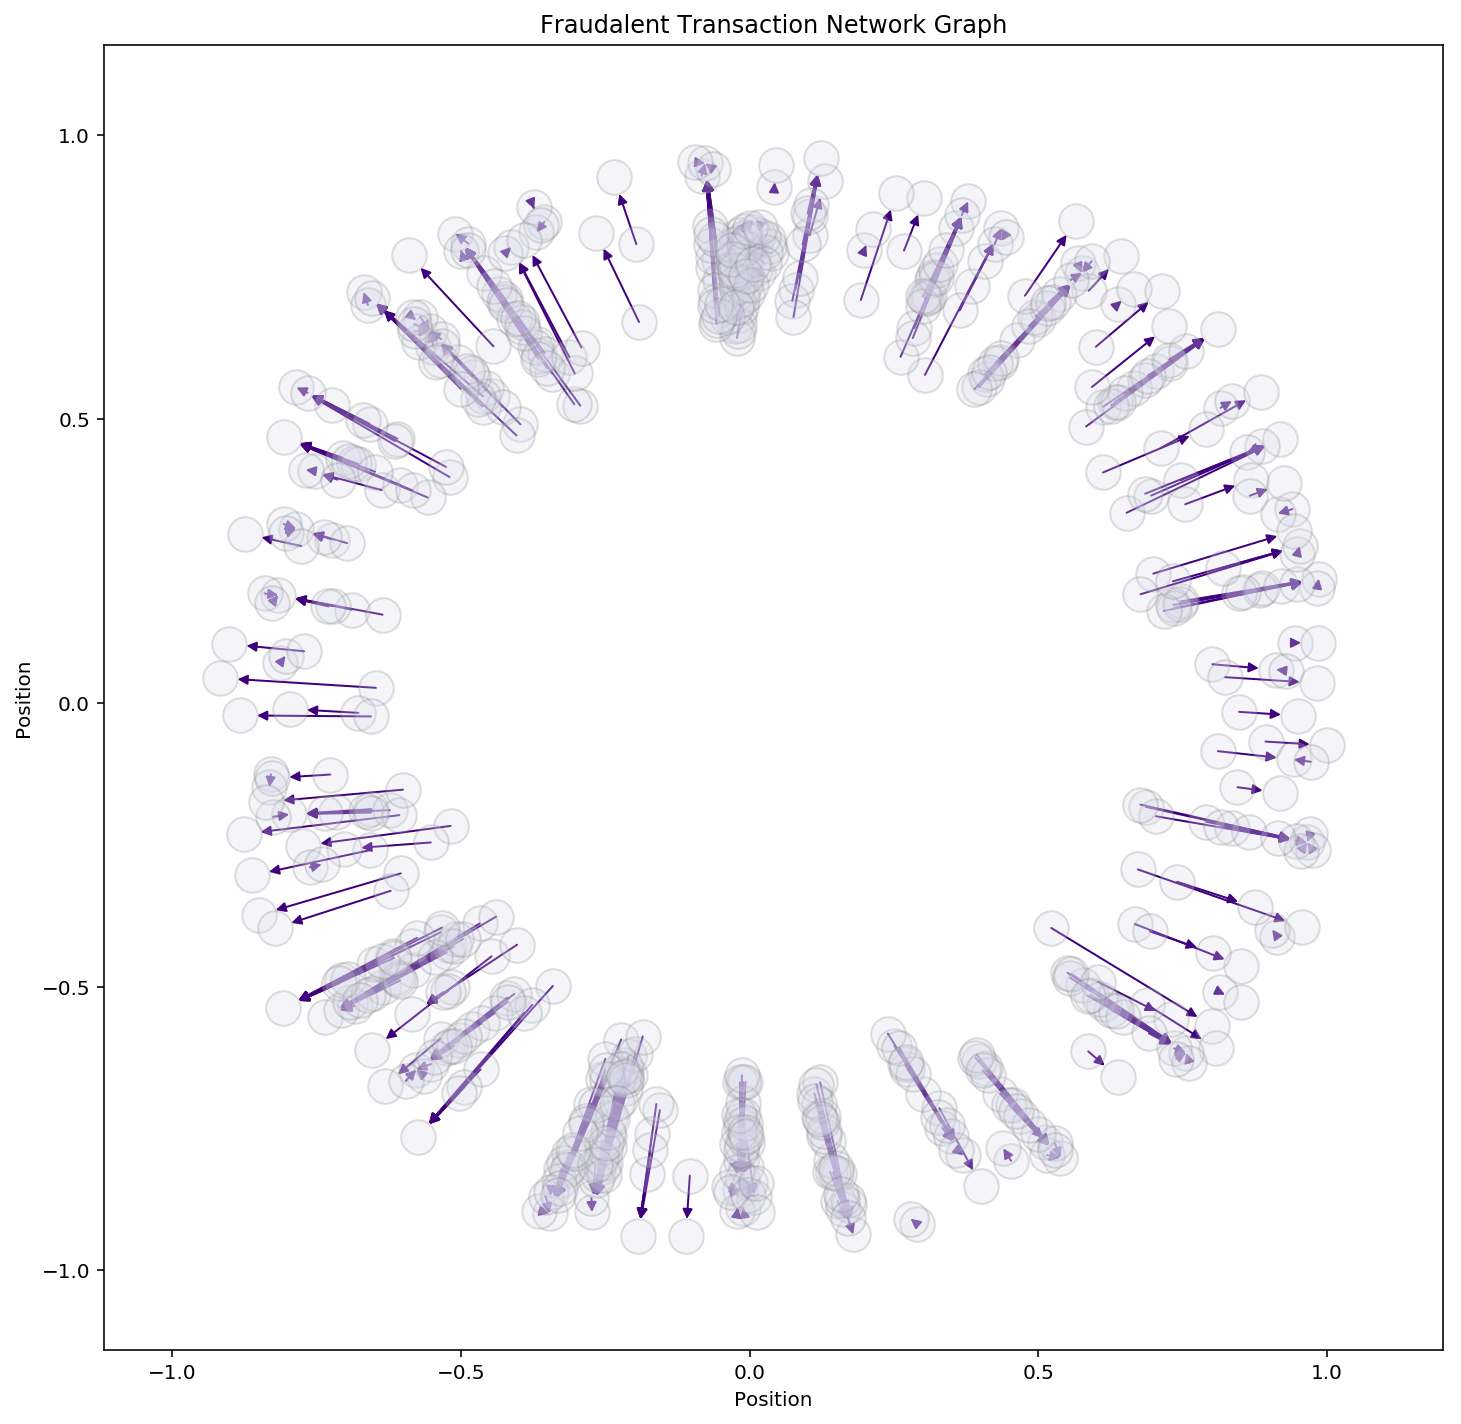

In [124]:
# Wrangle Network Data
fraud_case_accounts_sample = pd.Series(fraud_case_accounts_list).sample(100)

sdf_fraud_sample = sdf[(sdf.nameorig.isin(fraud_case_accounts_sample)) | (
    sdf.namedest.isin(fraud_case_accounts_sample))]
data = sdf_fraud_sample
data = data[['nameorig','namedest','target','amount']]
G = nx.DiGraph()

# Create temporary graph database/network
for i,j,k,l in list(data.itertuples(index=False, name=None)):
    G.add_edge(i,j, target=k, amount=l )

# Plot the graph network
pos=nx.spring_layout(G)
nx.draw_networkx_nodes(G,pos, alpha=0.25,
                       node_color='#dadaeb',
                       edgecolors='grey');
nx.draw_networkx_edges(G,pos,edge_color='#3f007d',
                       width=1);
plt.title('Fraudalent Transaction Network Graph')
plt.xlabel('Position')
plt.ylabel('Position');

### Preprocessing

Moving forward in the analysis I have subsampled the remaining data to only 100,000 records. I subsampled the data so I am able to run the modeling analysis and training on my laptop in a reasonable amount of time. 

When we encode our data we change all the object feature in both dataframe into a numeric representation of the data. For the KDD dataset, we encoded all non-anomalies to 0 and all anomalies to 1 to value in line with the encoding of our other datasets. With the Synthetic credit card dataset, we encoding our name_orig, name_dest, and type. We later one-hot-encode the type feature and append the new feature onto out dataset.


Afterwards, we subsample our data to 100,000.  

##### Feature Engineering

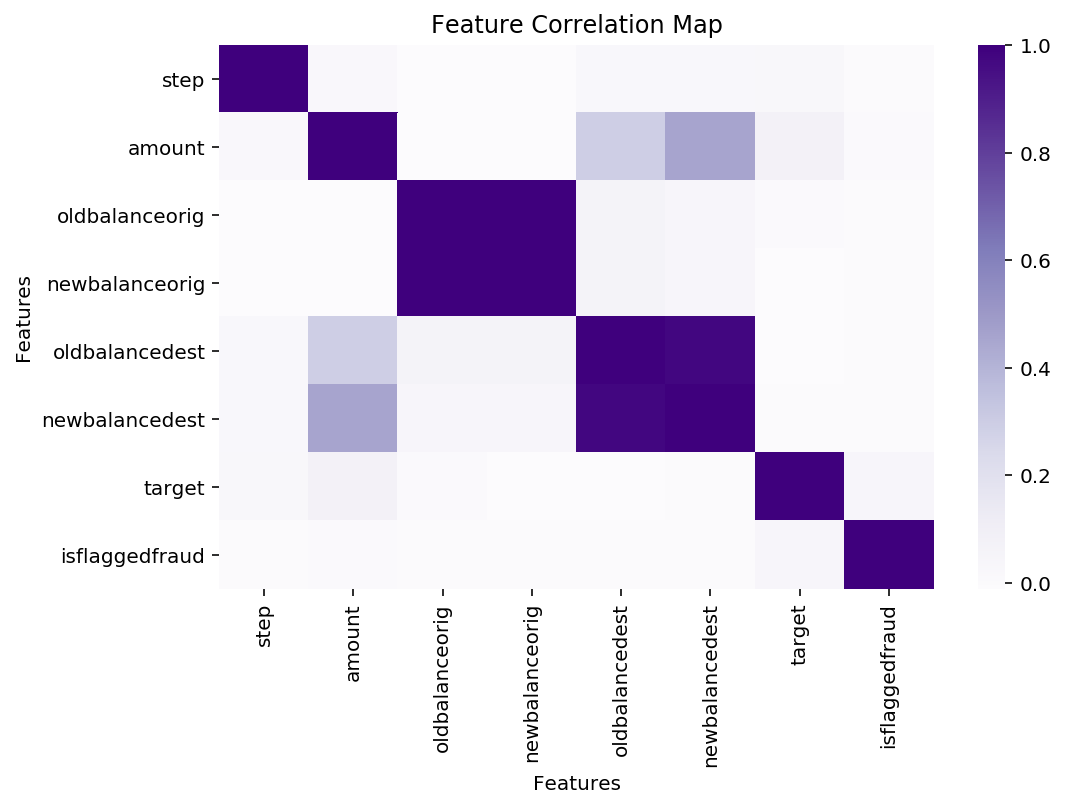

In [269]:
plt.figure(figsize=(8,5))
sns.heatmap(sdf.select_dtypes(['int','float']).corr(), 
            cmap=plt.cm.Purples);
plt.title('Feature Correlation Map');
plt.ylabel('Features')
plt.xlabel('Features')
plt.xticks(rotation='vertical');

We see that the new and old balance data feature are highly correlated with each other which is interesting so let's take a look a bitter closer. We can see from the summary statics provided above that the means are very close. To see how this correlation can relate to fraud we will segment the plot by target class at the same.

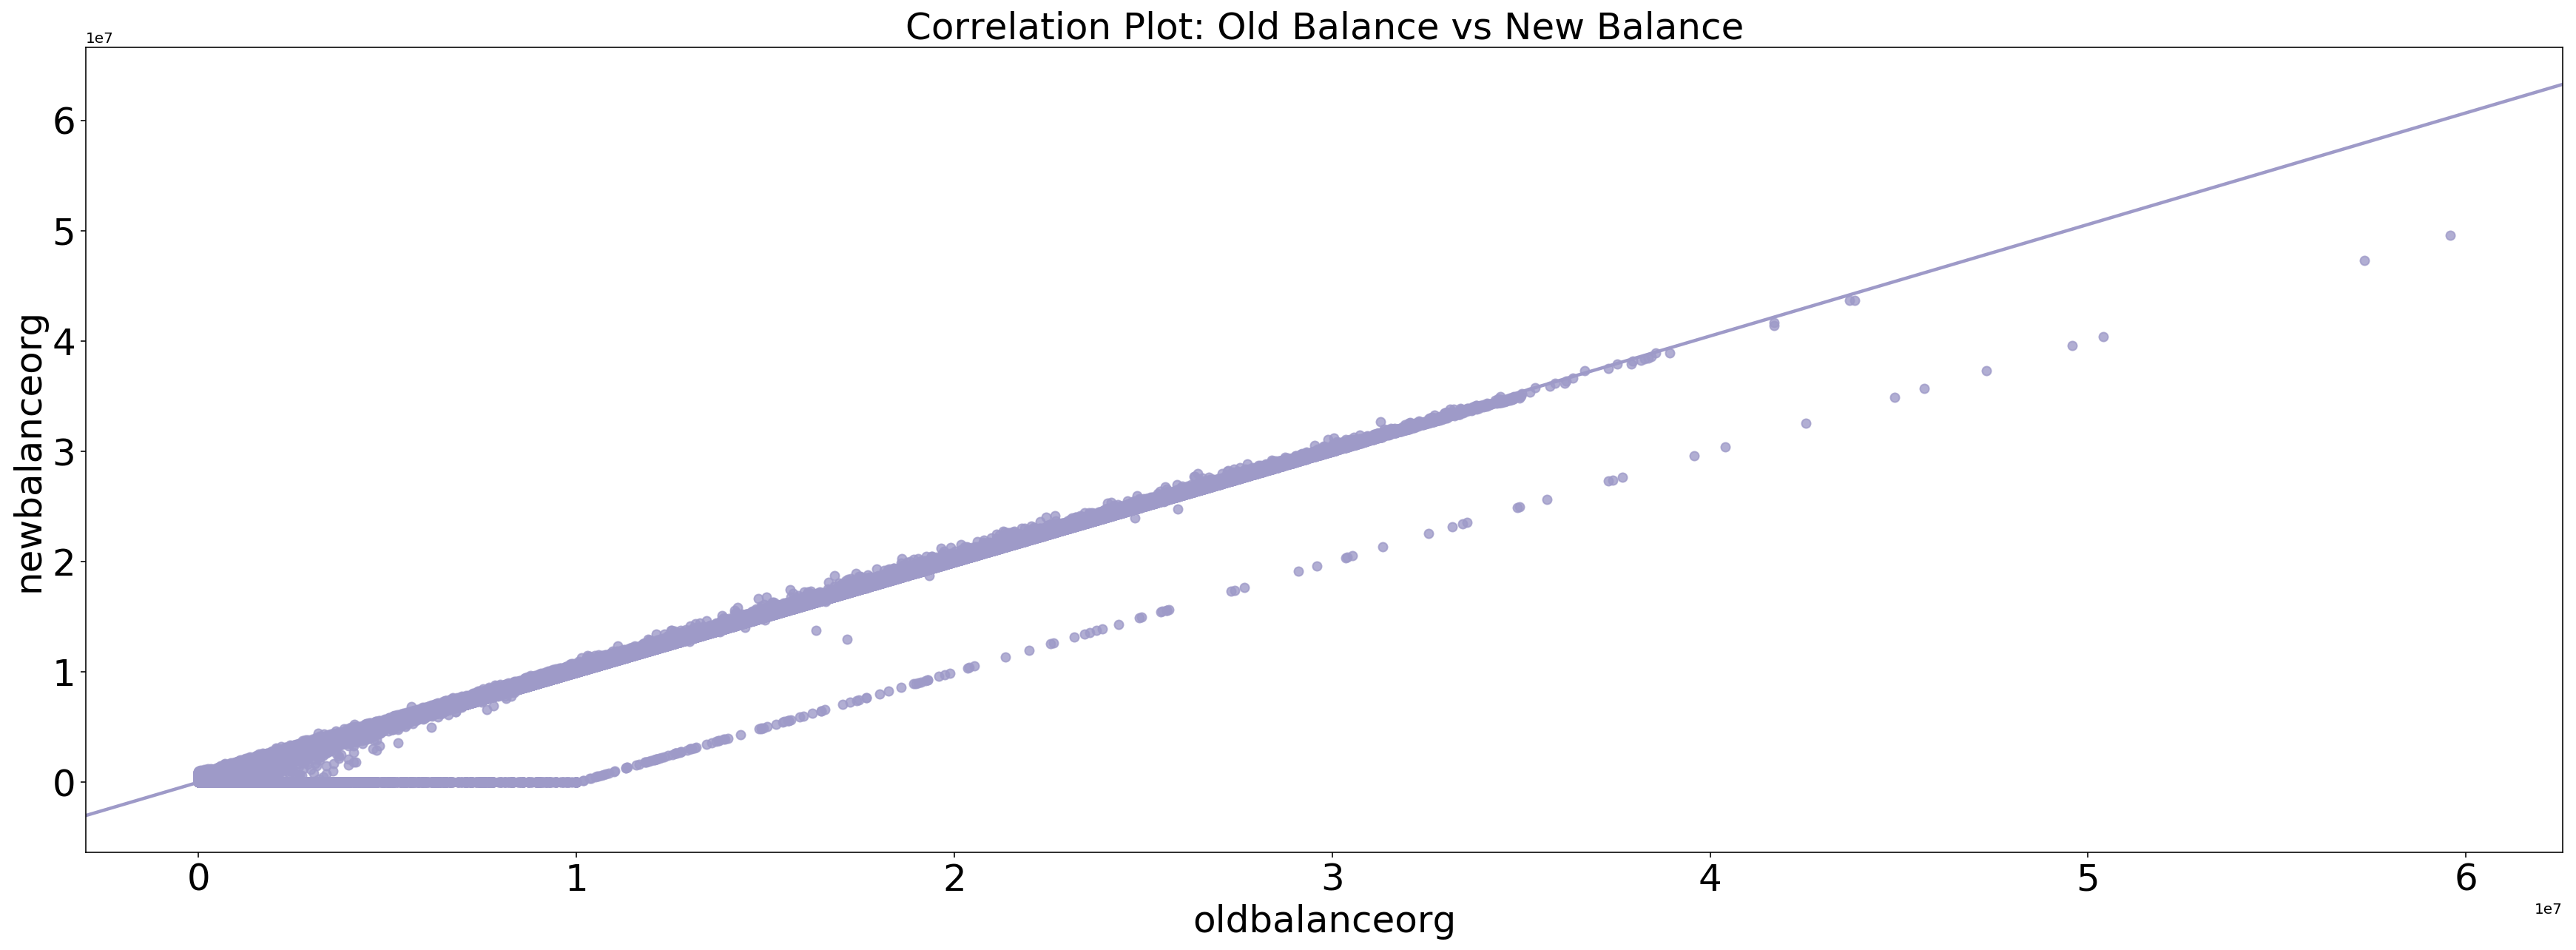

In [261]:
plt.figure(figsize=(30,10))
sns.regplot(x="oldbalanceorig", y="newbalanceorig", 
            data=sdf, color='#9e9ac8')
plt.title('Correlation Plot: Old Balance vs New Balance',fontsize=25)
plt.xlabel('oldbalanceorg', fontsize=25)
plt.ylabel('newbalanceorg',fontsize=25);
plt.yticks(fontsize=25);
plt.xticks(fontsize=25);

There to be a too different trend in the data. Since the transaction amount is slow the before and after balances remain relatively the same, so the value stary around the similar range. This makes why the feature would be highly correlated with each other.

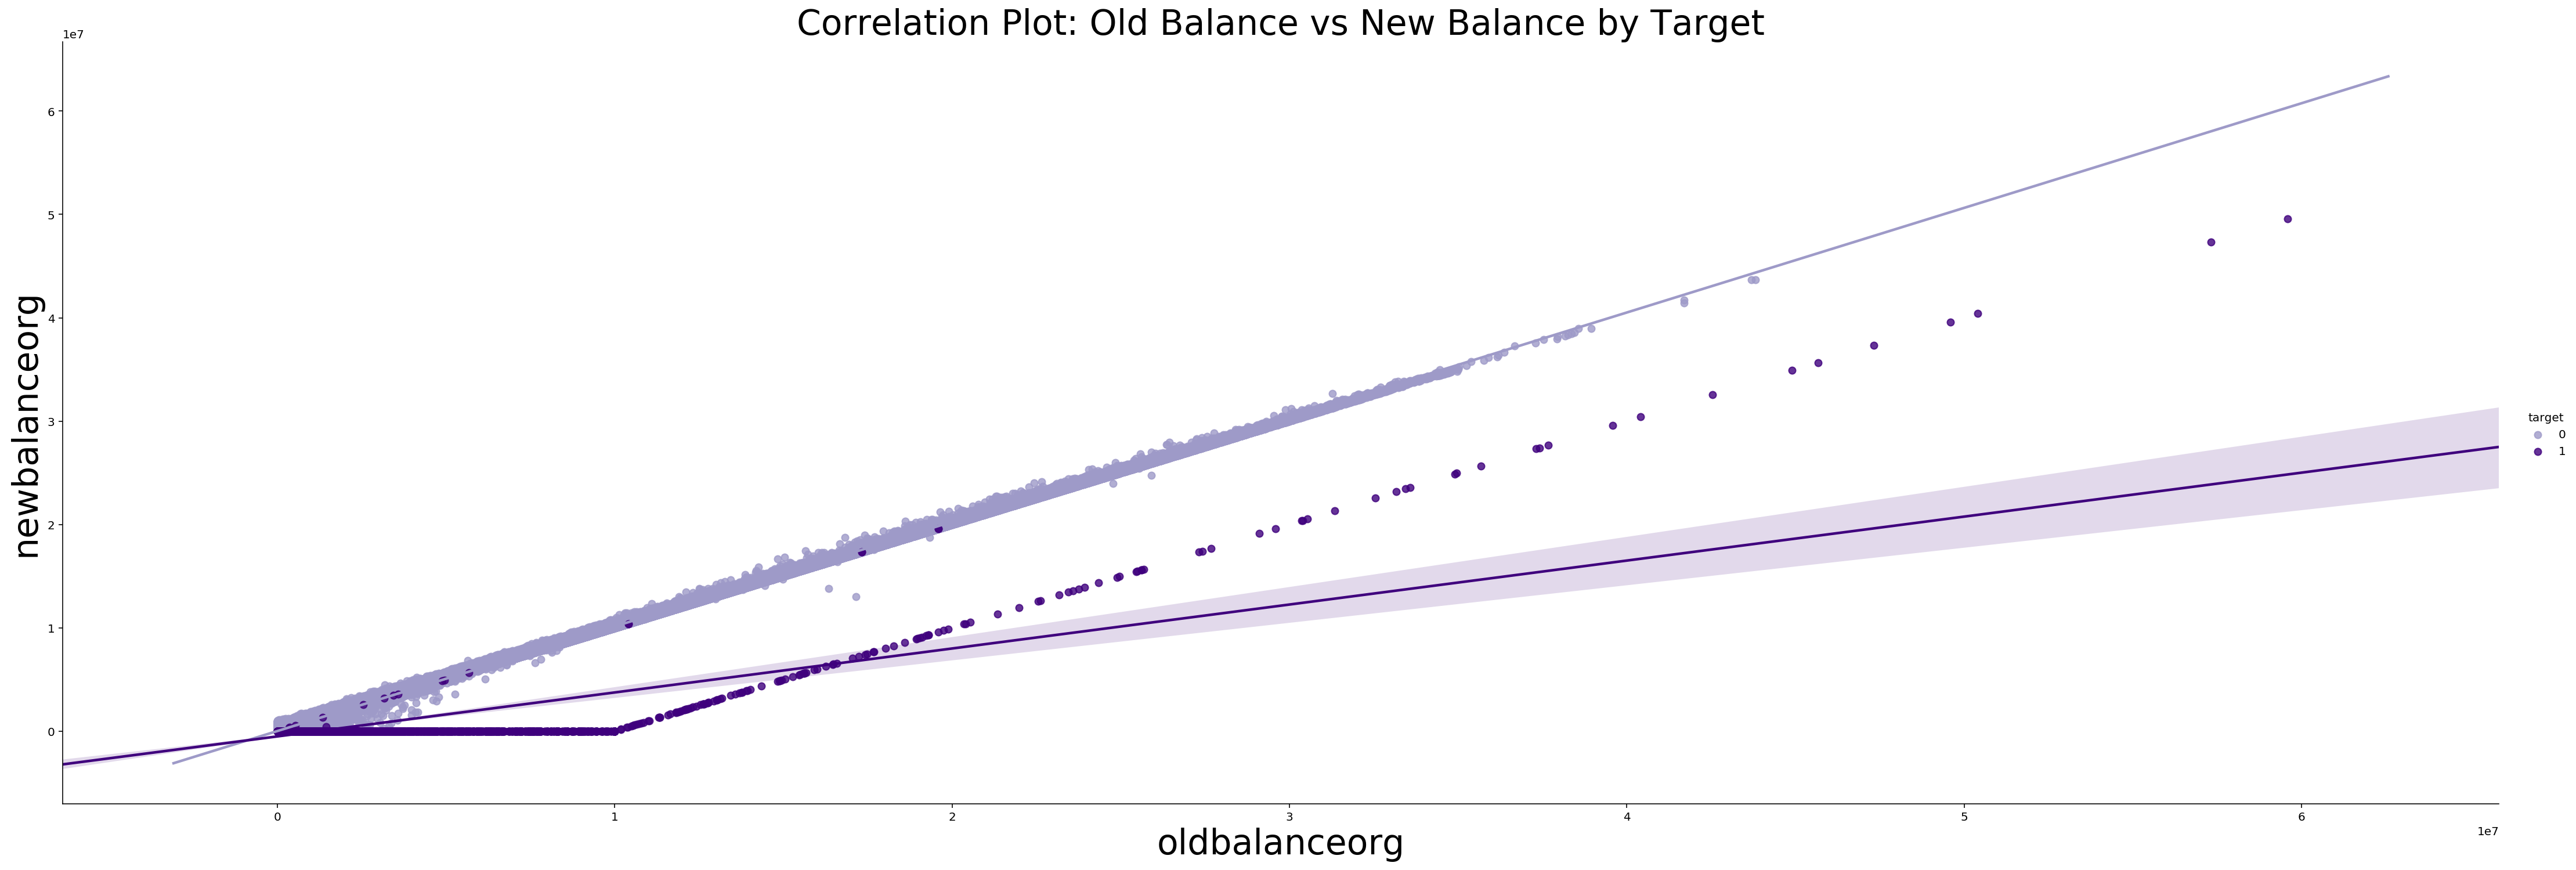

In [260]:
sns.lmplot(x="oldbalanceorig", y="newbalanceorig",  hue='target',
           data=sdf, size=10,aspect=3,
           palette=['#9e9ac8','#3f007d'])
plt.title('Correlation Plot: Old Balance vs New Balance by Target', 
          fontsize=30);
plt.xlabel('oldbalanceorg', fontsize=30)
plt.ylabel('newbalanceorg',fontsize=30);

It looks like the two trend in the data shows a difference between our target classes. Therefore this may not be a case a duplicate feature as the heat map suggest. The closely correlated feature may affect our KNN model as it may count the same value twice. So we will try building a KNN with and without the `oldbalanceorg` feature to view the difference.

Note: There is currently a bug in the lm.plot function that will not allow me to change the figure size or fontsize of this plot in uniform with the plot above.


##### Encoding Data

We are taking the following steps with encoding our data. We are encoding all the target value to 0 and 1, 0 being non-fraud/network attacks and 1 for fraud/network attack on all our datasets. That way when we interpret our confusion matrixes we are using consistent values. We are also encoding all the objects columns for all the feature in all our datasets. We drop the flagged is fraud feature from the Synthetics Credit Card Dataset as it is a source off of a data leak, and we also drop the Time feature for the from the Kaggle Credit Card Dataset. Since the Synthetic Dataset is the only dataset with a categorical feature for transaction type we will also dummy that feature out.

In [270]:
# Encode all object colunms to categorical codes
sdf.type = sdf.type.astype('category').cat.codes
sdf.nameorig = sdf.nameorig.astype('category').cat.codes
sdf.namedest = sdf.namedest.astype('category').cat.codes

# Drop is flagged false column
sdf = sdf.drop('isflaggedfraud', axis=1)

# Concatenate one-hot encoded type features
sdf = pd.concat([sdf,pd.get_dummies(sdf.type, 'type')], axis=1).drop('type',axis=1)

##### Train-Test Split

In [271]:
X = sdf.drop('target', axis=1).values
y = sdf.target.values
# Train-test split the data
X_train, X_test, y_train, y_test = train_test_split(X,y)

# Compute Sample Weights
weights = compute_sample_weight(class_weight='balanced', y=y_train)

### Evaluation Metrics
First, we are going to try some supervised approaches on our data. As we conduct our cross-validation for each model moving forwards we will want to store our cross-validation scores for each model so we can access our model afterward. I have created a few lists below that we will appending our scores too. 


- AUC ROC
- F1-Score
- Precision
- Recall

The recall is the number of correct results divided by the number of all the results. It tells us How many relevant items were select, calculated by the TP divided by the total number of relevant object in the area, which would be the TP + FN. Precision, on the other hand, tells us how many selected items are relevant, calculated by the taking the TP and dividing it by the total number of records we classified as positives, this would be our TP + FP. Maximizing precision or recall is relatively simple so we are also measuring the hyperbolic mean between these scores which is the F1 scores. Finally, our main metrics will be the Area under the ROC and AUC curve. The ROC is a plot to measure the difference between the TP rate and the FP rate. A ROC curve with more area under the cure is what we are actively looking for.

### Benchmark Models

For the next set of models I will be using a support vector machine as my benchmark model. Do show the communicate the difference in performance of the next few modesl.

Often the time we don't have the appropriate labels to train our supervised models. In these situations, we have to turn to supervise models and anomaly detection algorithms to detect anomalies. While these methods are not better performing that the supervised data above. We are getting decent results without labeling any of our data.

Outside of the Supervised and Unsupervised algorithms. We can use. If the have thresholding information on the number of anomalies within our dataset. We can use that threshold parameter and apply a set of anomaly detection algorithms to located incoming anomalies within our training set. All the algorithms in this section use the contamination rate parameters of dataset as one of there variables, value defined below.



<a id='envolope'></a>
##### Elliptic Envelope

Elliptic Envelope model goes about creating an ellipse around your data using and segment your outliers by placing an ellipsis boundary around your data. The algorithm assumes that your model is normally distributed as the model take bivariate samples of the dataset and uses multivariate Gaussian distribution to 


based on a robust estimator of covariance, which is assuming that the data are Gaussian distributed and performs better than the One-Class SVM in that case.


(unsupervised or supervised) it fits the tightest Gaussian (smallest volume ellipsoid) that it can while discarding some fixed fraction of contamination points set by the user.


A relatively simple model for the inlier-generating distribution is the multivariate Gaussian, which is parameterized by μ∈Rn
 and a covariance matrix Σ∈Rnxn
. This model can capture correlations between the data, so it can distort the Gaussian along any xi=x2
 line and take an ellipsoid shape generally. The class EllipticEnvelope takes your unlabeled X
 and fits such a multivariate Gaussian density to it.

In [272]:
rcParams['figure.figsize'] = (30.0, 10.0)
contamination_rate = (sdf['target'].value_counts()/sdf['target'].count())[1]
contamination_rate

0.001290820448180152

In [ ]:
# Build Elliptic Envelope Pipeline
ee_pipeline = make_pipeline(PCA(n_components=10),StandardScaler(), 
                            EllipticEnvelope(
                                contamination=contamination_rate))

# Run some cross validation on the pipeline
ee_scores = cross_validate(ee_pipeline,X_train,
                           target_to_anon(y_train),
                           cv=5, 
                           scoring='accuracy')

# Fit the pipline and return predictions
ee_pipeline.fit(X_train,y_train)
ee_pred = ee_pipeline.predict(X_train)

# Save Pipeline
joblib.dump(ee_pipeline, 'Models/fraud_ee_pipeline.sav')

# Plot Confusion Matrix
plot_confusion_anomoly(model=ee_pipeline, classes=[0,1], 
                      name = 'ee Pipeline',
                      train_x=X_train,
                      test_x=X_test,
                      train_y=y_train, test_y=y_test,
                      cmap= plt.cm.PuRd)

##### Support Vector Machine

As seen above our logisic regression does pretty well. But the model above is optimizing for accuracy. Let try using a support vector machine and tune our model against using a few diffrent solvers.

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

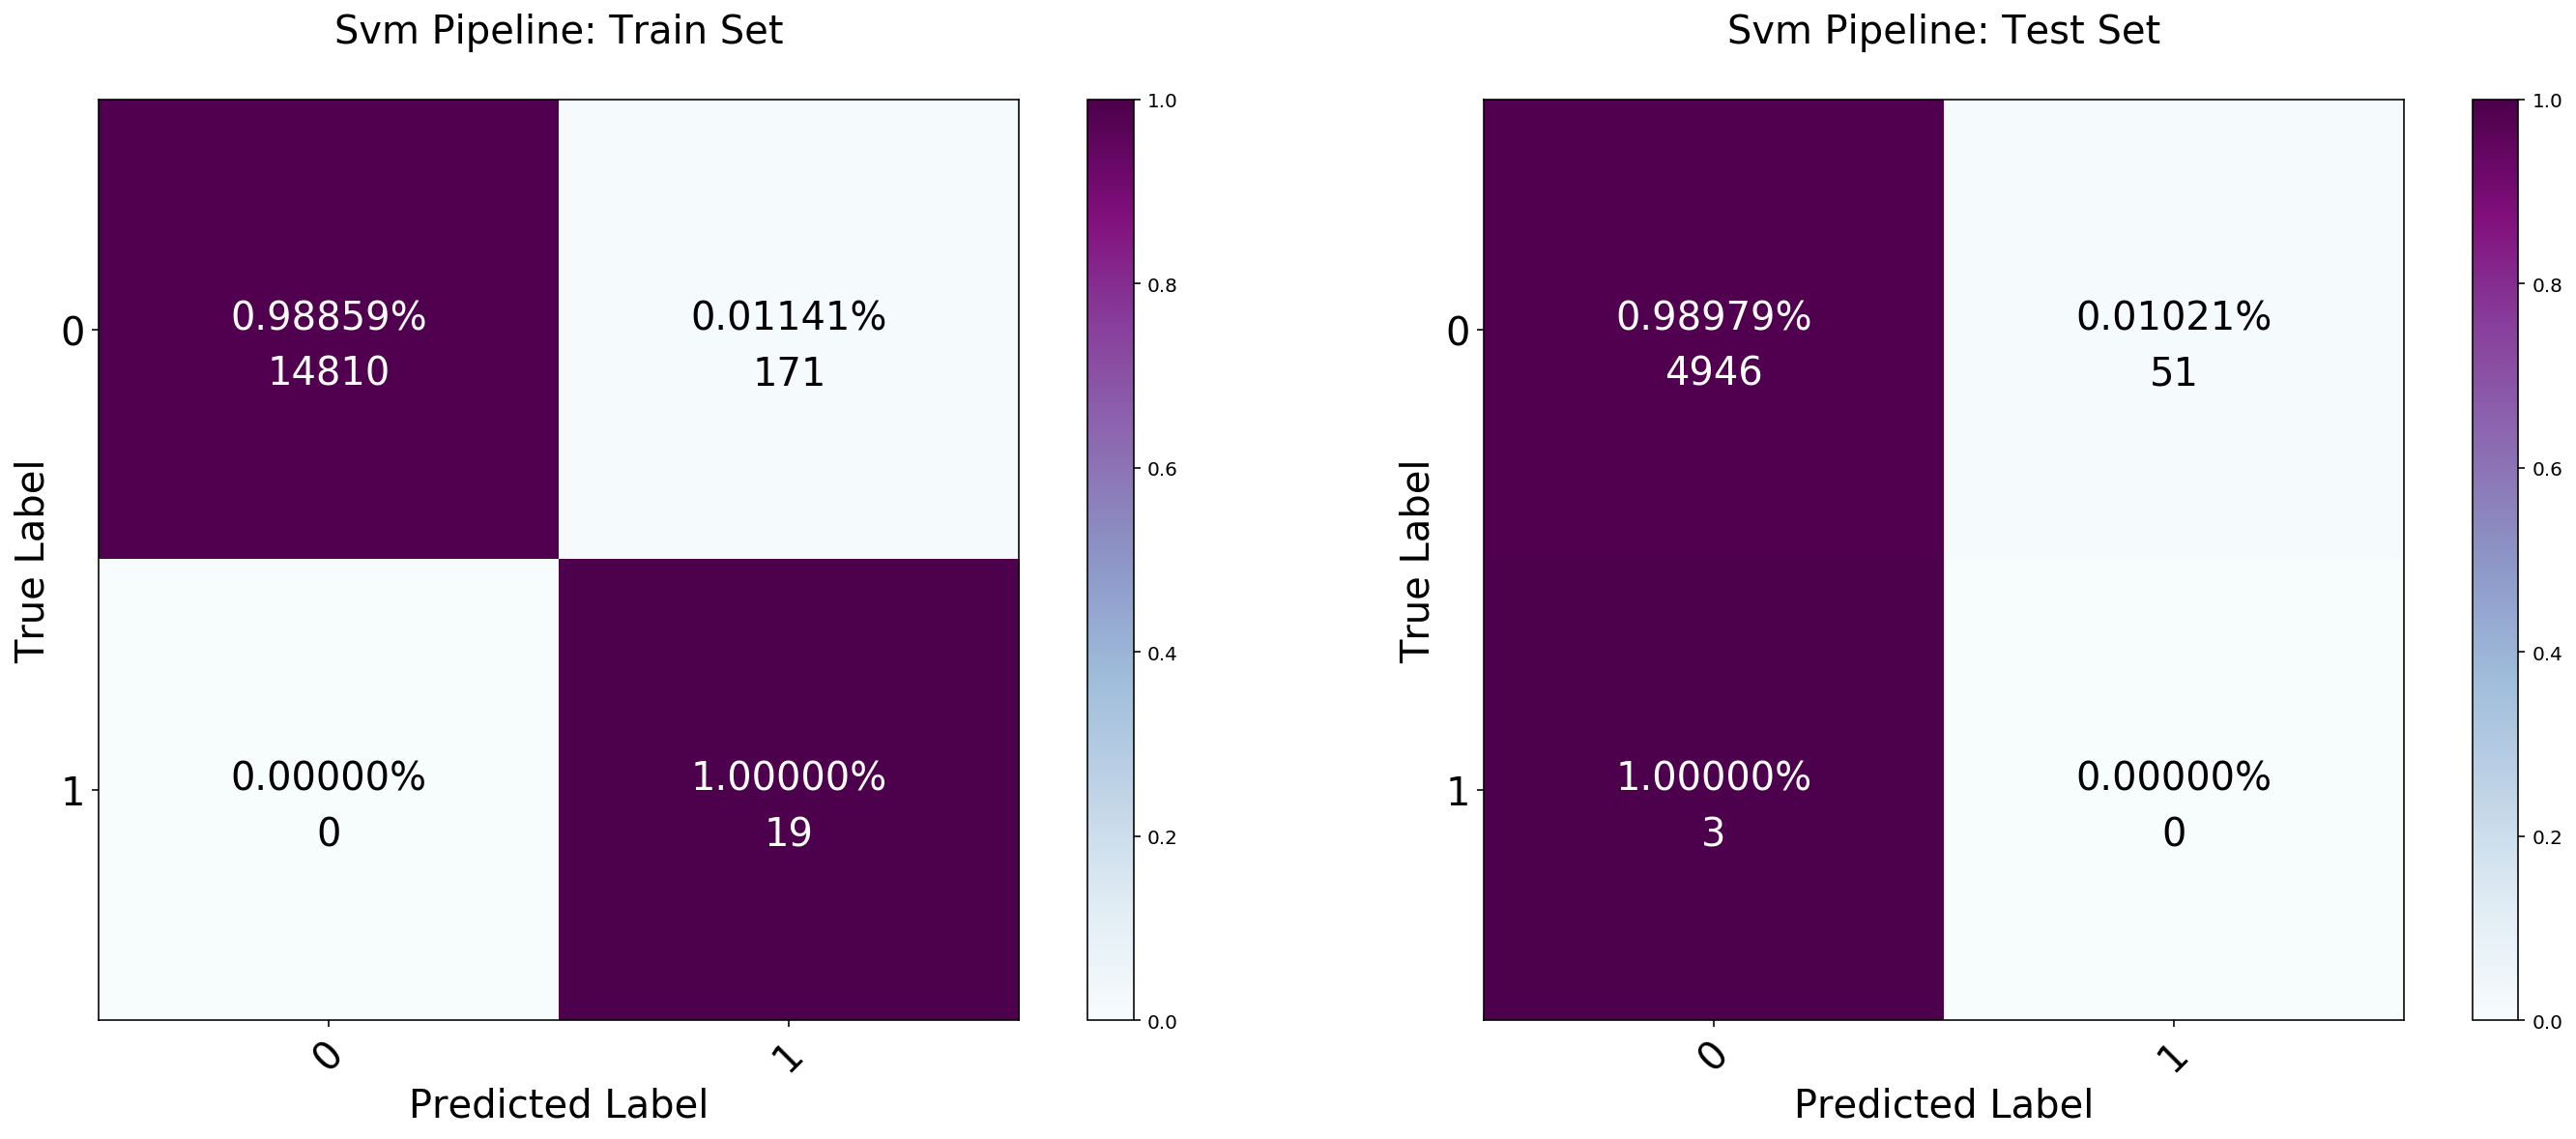

In [196]:
# Build Support Vector Machien Pipeline
svm_pipeline = make_pipeline(PCA(n_components=10),StandardScaler(), 
                            SVC(kernel='rbf',
                                verbose=1))
# Run some cross validation on the pipeline
svm_scores = cross_validate(svm_pipeline, X_train, y_train, cv=5, 
                           scoring='accuracy',
                           fit_params={'svc__sample_weight':weights})

# Fit the pipline and return predictions
svm_pipeline.fit(X_train,y_train, **{'svc__sample_weight':weights})
svm_pred = svm_pipeline.predict(X_train)

# Save Pipeline
joblib.dump(svm_pipeline, 'Models/fraud_svm_pipeline.sav')

# Plot Confusion Matrix
plot_confusion_normal(model=svm_pipeline, classes=[0,1], 
                      name = 'SVM Pipeline',
                      train_x=X_train, train_y=y_train,
                      test_x=X_test ,test_y=y_test,
                       cmap= plt.cm.BuPu)


### Unsupervised Appoarch


##### Isolation Forest
The isolation forest algorithm a random forest of trees to detect data and anomalies. The algorithm generates an ensemble of decisions tree that trained on feature and are randomly split on a value between the max and min value of that feature. Deep in the tree, random splitting continues. The go of an individual tree is to isolate each value in the data into a node. Once the tree has been fitted we can notice that anomalies are normally segmented into their noted very early on in the splitting process. What the model measures are the number of splits it took to push the anomalies down to its end node. For anomalies, it is common for its value to be segmented early on. Since isolation forest conduct this random over an ensemble of trees its common that on average anomalies with have the shorter path from the center. Therefore isolation forest uses a contamination rate to label points within the shorter pats anomalies.

using the Isolation Forest algorithm, which is based on random forests and hence more adapted to large-dimensional settings, even if it performs quite well in the examples below.

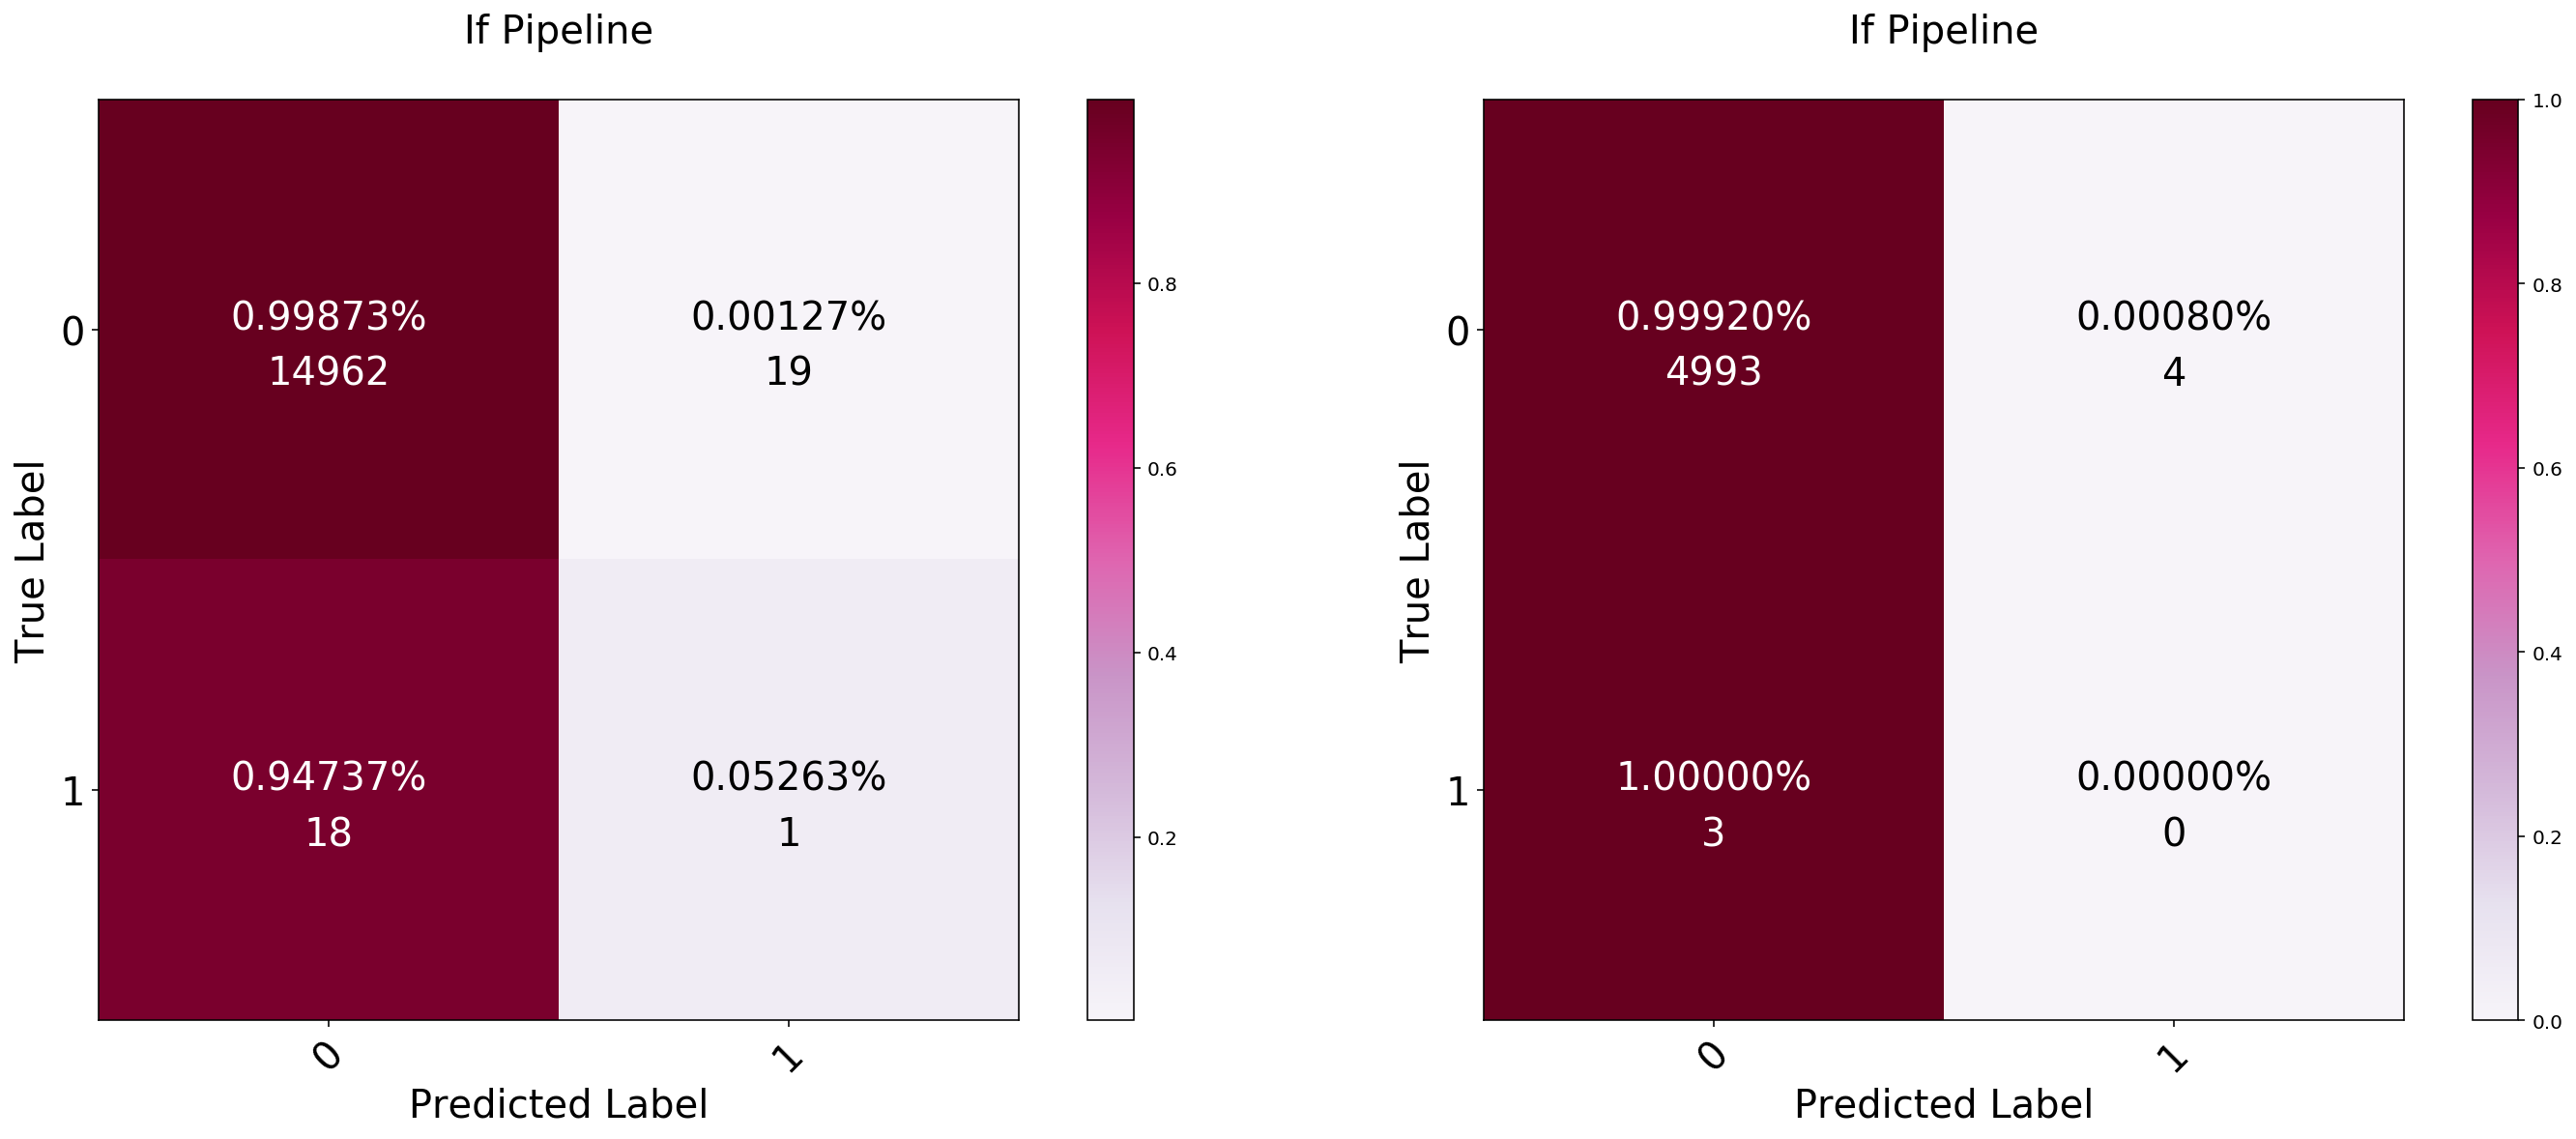

In [195]:
# Build Elliptic Envelope Pipeline
if_pipeline = make_pipeline(PCA(n_components=10),StandardScaler(), 
                            IsolationForest(
                                contamination=contamination_rate))

# Run some cross validation on the pipeline
if_scores = cross_validate(if_pipeline,X_train,
                           target_to_anon(y_train),
                           cv=5, 
                           scoring='accuracy',
                           fit_params={'isolationforest__sample_weight':weights})

# Fit the pipline and return predictions
if_pipeline.fit(X_train,y_train, **{'isolationforest__sample_weight':weights})
if_pred = if_pipeline.predict(X_train)

# Save Pipeline
joblib.dump(if_pipeline, 'Models/fraud_if_pipeline.sav')

# Plot Confusion Matrix
plot_confusion_anomoly(model=if_pipeline, classes=[0,1], 
                      name = 'if Pipeline',
                      train_x=X_train,
                      test_x=X_test,
                      train_y=y_train, test_y=y_test,
                       cmap= plt.cm.PuRd)

<a id='onescm'></a>
### One Class SVM
A one class support vector machine is basically similar to a modern SVM, the key difference here is that we only train the model using only the non anomaly class data. The support vector machine then builds a linear boundary around the data. When classifying new data, any data that lands outside this decision boundary is classified as an anomaly. This dataset type of model provides robustness for predicting future anomalies. As we can assume those future anomalies with ly outside our normal training data and will be caught outside our model's linear boundary.
One-Class SVM and its ability to capture the shape of the data set, hence performing better when the data is strongly non-Gaussian, i.e. with two well-separated clusters

##### Normal Training Set

In [ ]:
# Isolating Calss 0 only Training 
train_y_both = pd.Series(train_y)
#print(train_y_both.value_counts())
normal_index = np.where(train_y_both==0)
train_x_normal = train_x[normal_index]
train_y_normal = train_y[normal_index]
train_x_normal;

In [ ]:
# Class 0 only Training 
train_y_both = pd.Series(train_y)
print(train_y_both.value_counts())
normal_index = np.where(train_y_both==0)
train_x_normal = train_x[normal_index]
train_y_normal = train_y[normal_index]
train_x_normal

# One Class  Support Vetor Machine
oc_model = OneClassSVM(nu = contamination_rate, gamma =0.0005)
oc_model.name = 'one_class_svm_training_set'
oc_model.fit(train_x_normal)

#Cross Validation, Plot, Save
cross_validate_anomoly(oc_model, cv = 5,  fit_params={'sample_weight':weights}, 
                 verbose=0, train_y=target_to_anon(train_y), 
                 train_x=train_x)
plot_confusion_anomoly(oc_model, train_y, test_y)
joblib.dump(oc_model, 'Model/'+oc_model.name+'_'+working_file_name+'.sav');

##### Full Training Set
When I was reaching this alogrithim. I was not 100% sure the it only tookin the training data or the normal class. Therefore I want to conduct some senstivity analysis. Below refit the model again but on the entire training set. As I contaminate the dataset I wanted to see what woould happen. 

In [ ]:
pd.Series(target_to_anon(train_y)).value_counts()

In [ ]:
ocf_model = OneClassSVM(nu = contamination_rate, gamma =0.0005)
ocf_model.name = 'one_class_svm_full_training_set'
ocf_model.fit(train_x, sample_weight = weights)

cross_validate_anomoly(ocf_model, cv = 5,  fit_params={'sample_weight':weights}, 
                 verbose=0, train_y=target_to_anon(train_y),
                 train_x=train_x)

plot_confusion_anomoly(ocf_model, train_y, test_y, cmap=plt.cm.BuPu)
joblib.dump(ocf_model, 'Model/'+ocf_model.name+'_'+working_file_name+'.sav');

# <a id='dtc'></a>
### Supervised Models
Decision Tree are popular models as they are easy to intrepret to the humman eye. This makes them more advantagous to use compare to the KNN model. The Decision tree will split the data based on this gini coefficent and make the apporiate split in the data that maximized the our roc auc score.

##### Random Forest Classifier

The scores of decision tree can change dermaticaly the often we run the model. Therefore using random forest model with give us the benefits of the decision tree with the add stabaility of an ensemble to stabilize our results. You see that I did an model with and without PCA information again.

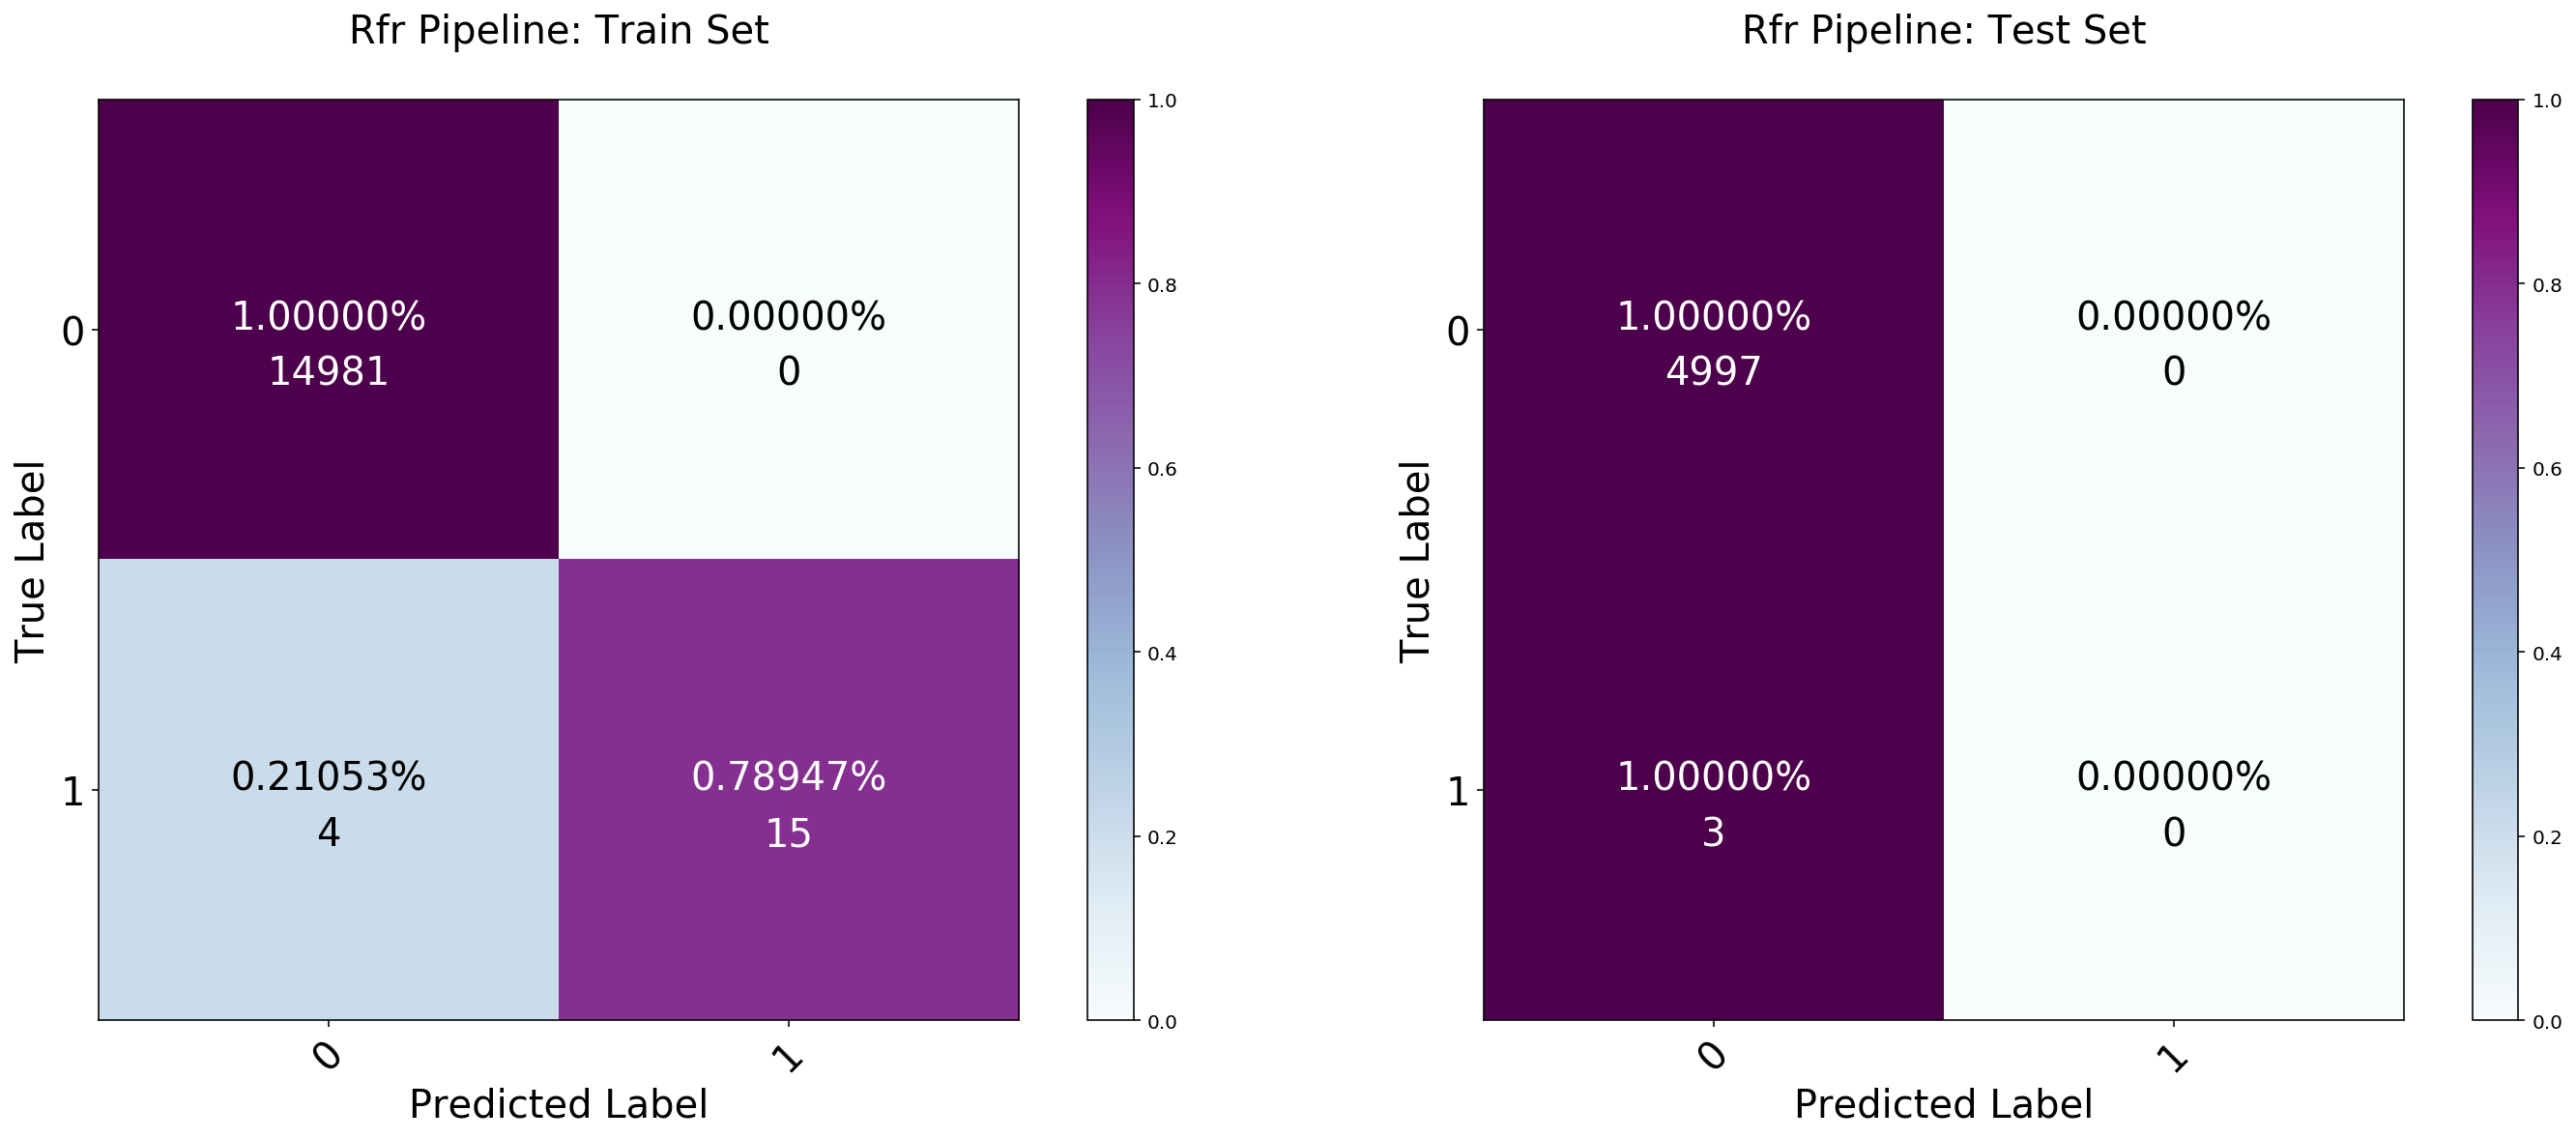

In [194]:
# Build Support Vector Machien Pipeline
rfr_pipeline = make_pipeline(PCA(n_components=10),StandardScaler(), 
                            RandomForestClassifier())
# Run some cross validation on the pipeline
rfr_scores = cross_validate(rfr_pipeline, X_train, y_train, cv=5, 
                           scoring='accuracy',
                           fit_params={'randomforestclassifier__sample_weight':weights})

# Fit the pipline and return predictions
rfr_pipeline.fit(X_train,y_train, **{'randomforestclassifier__sample_weight':weights})
rfr_pred = rfr_pipeline.predict(X_train)

# Save Pipeline
joblib.dump(rfr_pipeline, 'Models/fraud_rfr_pipeline.sav')

# Plot Confusion Matrix
plot_confusion_normal(model=rfr_pipeline, classes=[0,1], 
                      name = 'rfr Pipeline',
                      train_x=X_train, train_y=y_train,
                      test_x=X_test ,test_y=y_test,
                      cmap= plt.cm.BuPu)


##### XG Boost

XG Boost is basically an Random Forest model that support Boost Procedure after generating the ensemble of Random Forests. As this is normally the most dominent algorithim in the competive machine learning space. Lets attempt this model next. 

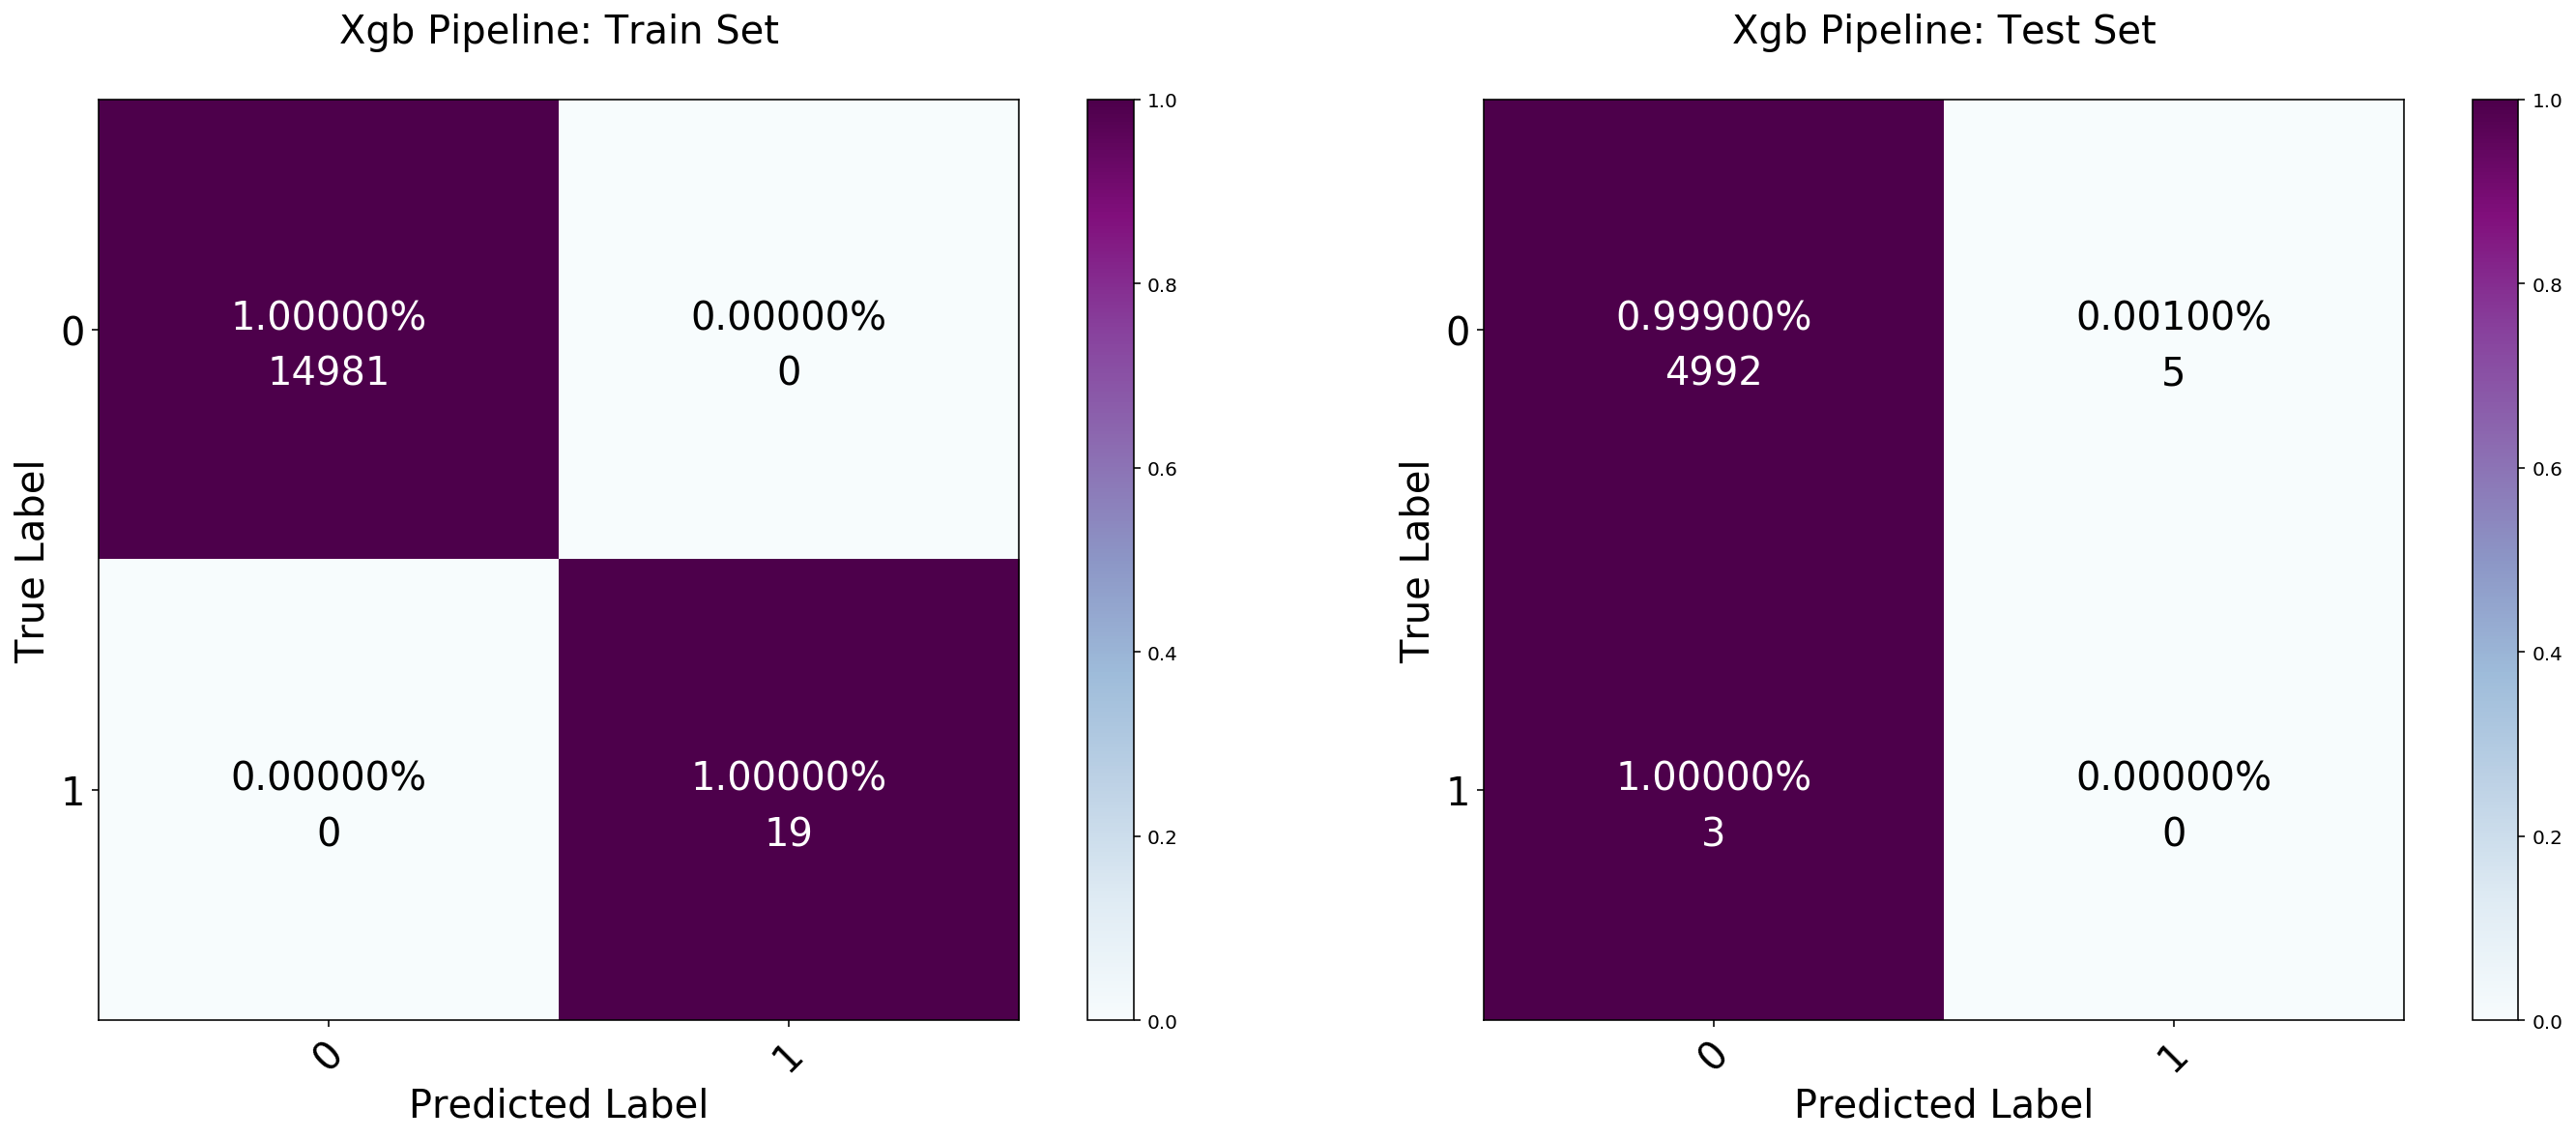

In [198]:
# Build Support Vector Machien Pipeline
xgb_pipeline = make_pipeline(PCA(n_components=10),StandardScaler(), 
                             XGBClassifier(max_depth=10))
# Run some cross validation on the pipeline
xgb_scores = cross_validate(xgb_pipeline, X_train, y_train, cv=5, 
                           scoring='accuracy',
                           fit_params={'xgbclassifier__sample_weight':weights})

# Fit the pipline and return predictions
xgb_pipeline.fit(X_train,y_train, **{'xgbclassifier__sample_weight':weights})
xgb_pred = xgb_pipeline.predict(X_train)

# Save Pipeline
joblib.dump(xgb_pipeline, 'Models/fraud_xgb_pipeline.sav')

# Plot Confusion Matrix
plot_confusion_normal(model=xgb_pipeline, classes=[0,1], 
                      name = 'xgb Pipeline',
                      train_x=X_train, train_y=y_train,
                      test_x=X_test ,test_y=y_test,
                      cmap= plt.cm.BuPu)


It seem that that our roc_auc scoring metric has run into a rounding error. Let ignore the score now and just compare the number of FP and FN. 

<a id='autoencoder'></a>
##### Tangent: Auto Encoders

An autoencoder is a specialized neural network that instead of predicting with target values with the training features, it goes otherwise will instead be to attempt to recreate its training data with after passing the data through a bottleneck within the network. All the neurons before the network encode the data and all the neurons after the bottle decode the data that has reached the bottle neck. In the case of this example and we will train the auto encoder with all our training data and attempt to recreate the same using the neural network minus the outliers. When we have the data without we will compare the generated data with the training data and omit a reconstruction error for each observation in our training set. Once we have this information we can use a certain reconstruction error as a threshold to predict and isolate our anomalies. This model has been cited from this <a href='https://medium.com/@curiousily/credit-card-fraud-detection-using-autoencoders-in-keras-tensorflow-for-hackers-part-vii-20e0c85301bd'>source</a> as it is similar in structure.

### Conslusion
As you can see from the model leaderboards above, which have been sorted by the mean_test_auc_roc scores from our customer cross-validation function. Ensembling tree method dominates the 5 top leaderboards. After looking at these results we can conclude that for our datasets similar to these 3, a tree-based method would be the best way to approach the problem. Most Fraud/Network attack dataset contains a high amount of dimensionality, and tree-based method normally excels datasets with high dimensionality. The intended nature of the fraudulent outliers in the data also makes it difficult for threshold models to perform accurately on the data. We see these results in scores of base autoencoder and thresholding models.

### Sources

- [AutoEncoder in Keras](https://medium.com/@curiousily/credit-card-fraud-detection-using-autoencoders-in-keras-tensorflow-for-hackers-part-vii-20e0c85301bd)
- [Coloring Decitions Trees](https://stackoverflow.com/questions/42891148/changing-colors-for-decision-tree-plot-created-using-export-graphviz)
- [Density Based Clustering](https://www.youtube.com/watch?v=5cOhL4B5waU)
- [HDSCAN](https://www.youtube.com/watch?v=AgPQ76RIi6A)
- [Mean Shift Clustering](https://spin.atomicobject.com/2015/05/26/mean-shift-clustering/)
- [Oultier  Detection](https://plot.ly/scikit-learn/plot-outlier-detection/)


Author: Kavi Sekhon